In [322]:
import os
import re
import numpy as np
import pandas as pd
import sklearn

from sklearn.metrics import f1_score, classification_report, confusion_matrix

import sys

sys.path.append("../..")

In [323]:
# CONSTANTS

CLEANING_METHODS = [
        "aum",
        "cincer",
        "cleanlab",
        "simifeat"
    ]

In [324]:
# Config

BASE_PATH = "/zfsauton/data/public/vsanil/aqua_results"

FOLDER_PATTERN = f"results_(?P<timestamp>.*)_randomseed_(?P<randomseed>.*)_(?P<basemodel>.*)"
FILE_PATTERN = f"(?P<dataset>.*)_(?P<noisetype>.*)_label_issues.csv"

In [325]:
# Read results

results_dict = dict()

result_dirs = os.listdir(BASE_PATH)
result_dirs.sort()
for result_dir in result_dirs:
    re_folder = re.match(FOLDER_PATTERN, result_dir)
    print(result_dir, re_folder)
    time_stamp = re_folder.group("timestamp")
    random_seed = re_folder.group("randomseed")
    base_model = re_folder.group("basemodel")
    result_dir_path = os.path.join(BASE_PATH, result_dir)
    for filename in os.listdir(result_dir_path):
        re_file = re.match(FILE_PATTERN, filename)
        if not re_file:
            continue
        dataset = re_file.group("dataset")
        noise_type = re_file.group("noisetype")
        if dataset not in results_dict:
            results_dict[dataset] = dict()
        if base_model not in results_dict[dataset]:
            results_dict[dataset][base_model] = dict()
        if noise_type not in results_dict[dataset][base_model]:
            results_dict[dataset][base_model][noise_type] = dict()
        if random_seed not in results_dict[dataset][base_model][noise_type]:
            results_dict[dataset][base_model][noise_type][random_seed] = dict()
        data_path = os.path.join(result_dir_path, filename)
        results_dict[dataset][base_model][noise_type][random_seed]["datacard"] = pd.read_csv(data_path, index_col=0)


results_2023-05-31-01-09-58_randomseed_42_resnet1d <re.Match object; span=(0, 50), match='results_2023-05-31-01-09-58_randomseed_42_resnet1>
results_2023-05-31-01-10-38_randomseed_42_resnet1d <re.Match object; span=(0, 50), match='results_2023-05-31-01-10-38_randomseed_42_resnet1>
results_2023-05-31-01-11-08_randomseed_42_resnet1d <re.Match object; span=(0, 50), match='results_2023-05-31-01-11-08_randomseed_42_resnet1>
results_2023-05-31-01-12-24_randomseed_42_resnet1d <re.Match object; span=(0, 50), match='results_2023-05-31-01-12-24_randomseed_42_resnet1>
results_2023-06-01-13-32-58_randomseed_42_resnet1d <re.Match object; span=(0, 50), match='results_2023-06-01-13-32-58_randomseed_42_resnet1>
results_2023-06-01-13-33-15_randomseed_44_resnet1d <re.Match object; span=(0, 50), match='results_2023-06-01-13-33-15_randomseed_44_resnet1>
results_2023-06-01-13-37-33_randomseed_43_resnet1d <re.Match object; span=(0, 50), match='results_2023-06-01-13-37-33_randomseed_43_resnet1>
results_2023-

In [326]:
# Processed Datasets

results_dict.keys()

dict_keys(['electricdevices', 'crop', 'mitbih', 'pendigits', 'whalecalls', 'adult', 'dry_bean', 'credit_fraud', 'car_evaluation', 'mushrooms', 'compas', 'cifar10', 'clothing100k', 'cxr', 'imdb', 'tweeteval'])

In [327]:
# Sample Datacard

results_dict["cxr"]["mobilenet-v2"]["asymmetric-0.1"]["42"]

{'datacard':        is_injected_noise  noisy_label  label_issues_simifeat  \
 0                      0            0                      0   
 1                      0            0                      0   
 2                      0            0                      0   
 3                      1            1                      0   
 4                      0            0                      0   
 ...                  ...          ...                    ...   
 17805                  0            0                      0   
 17806                  0            0                      0   
 17807                  0            0                      0   
 17808                  0            1                      0   
 17809                  0            0                      0   
 
        preds_cleaned_simifeat  label_issues_aum  preds_cleaned_aum  \
 0                           0                 0                  0   
 1                           0                 0                

In [328]:
import numpy as np
import sklearn.metrics as skm
from aqua.metrics import get_metrics, f1_score

In [329]:
# Calculate Cleaning Method Performance

metrics = ["f1", "weighted_f1", "accuracy", "precision", "recall", "error_rate"]
    
for dataset in results_dict:
    for base_model in results_dict[dataset]:
        for noise_type in results_dict[dataset][base_model]:
            for random_seed in results_dict[dataset][base_model][noise_type]:
                datacard = results_dict[dataset][base_model][noise_type][random_seed]["datacard"]
                if len(datacard.columns) != 11:
                    continue
                    
                results_dict[dataset][base_model][noise_type][random_seed]["cleaning_method_performance"] = dict()
                cm_performance_dict = results_dict[dataset][base_model][noise_type][random_seed]["cleaning_method_performance"]
                for cleaning_method in CLEANING_METHODS:
                    results = get_metrics(datacard["is_injected_noise"], datacard[f"label_issues_{cleaning_method}"])
                    noise_pred_results = {metric:result for (metric, result) in zip(metrics, results)}
                    noisy_datacard = datacard[datacard["is_injected_noise"] == 1]
                    results = get_metrics(noisy_datacard["noisy_label"], noisy_datacard[f"preds_cleaned_{cleaning_method}"])
                    noisy_label_pred_results = {metric:result for (metric, result) in zip(metrics, results)}
                    cm_performance_dict[f"{cleaning_method}_noise_pred"] = noise_pred_results
                    cm_performance_dict[f"{cleaning_method}_noisy_label_pred"] = noisy_label_pred_results
                    
                #results_dict[dataset][base_model][noise_type][random_seed]["downstream_model_performance"] = dict()
                #dm_performance_dict = results_dict[dataset][base_model][noise_type][random_seed]["downstream_model_performance"]

In [330]:
# Calculate Downstream Performance


from tqdm import tqdm
import aqua.data.preset_dataloaders as presets
from aqua.configs import main_config, data_configs, model_configs

FILE_PATTERN = f"(?P<dataset>.*)_(?P<downstream_model>.*)_(?P<noise_type>.*)_(?P<cleaning_method>.*)_(?P<random_seed>.*)_test_preds.csv"
base_downstream_model_path = "/zfsauton/data/public/vsanil/aqua/aqua_downstream_models/"

#base_model = "all-MiniLM-L6-v2"
# base_model = "resnet18"
# downstream_model = base_model
# random_seed_filters = ("42")
# dataset_filters = ("cifar10")
dataset_test_labels = dict()

results = dict()

result_files = os.listdir(base_downstream_model_path)
result_files.sort()
for result_file in tqdm(result_files):
    result_file = result_file.replace("mobilenet_v2", "mobilenet-v2")
    re_file = re.match(FILE_PATTERN, result_file)
    dataset = re_file.group("dataset")
#     if dataset not in dataset_filters:
#         continue
    downstream_model = re_file.group("downstream_model")
    noise_type = re_file.group("noise_type")
#     if "-" in noise_type and any([noise_type.endswith(noise_rate) for noise_rate in noise_rate_filters]):
#         continue
    cleaning_method = re_file.group("cleaning_method")
    random_seed = re_file.group("random_seed")
    result_file = result_file.replace("mobilenet-v2", "mobilenet_v2")
    
#     if random_seed not in random_seed_filters:
#         continue
    
#     if base_model != downstream_model:    # TODO: Handle this
#         continue

    if noise_type == "nonoise":
        continue
    if "downstream_model_performance" not in results_dict[dataset][downstream_model][noise_type][random_seed]:
        results_dict[dataset][downstream_model][noise_type][random_seed]["downstream_model_performance"] = dict()
    dm_performance_dict = results_dict[dataset][downstream_model][noise_type][random_seed]["downstream_model_performance"]
    
    if dataset not in dataset_test_labels:
        data_aq, data_aq_test = getattr(presets, f'load_{dataset}')(data_configs[dataset])
        dataset_test_labels[dataset] = data_aq_test.labels

    print(result_file)
    result_file = os.path.join(base_downstream_model_path, result_file)
    y_pred = pd.read_csv(result_file, header=None)[0]
    
    test_results = get_metrics(dataset_test_labels[dataset], y_pred)
    dm_performance_dict[cleaning_method] = test_results
    #print(f"{test_results[1]}\t\t{dataset}_{noise_type}_{cleaning_method}_results")
    
    run_name = f"{noise_type}_{cleaning_method}"
    if dataset not in results:
        results[dataset] = dict()
    results[dataset][run_name] = test_results[1] 

  0%|▏                                                  | 6/1521 [00:00<01:03, 23.81it/s]

adult_mlp_asymmetric-0.1_aum_42_test_preds.csv
adult_mlp_asymmetric-0.1_aum_43_test_preds.csv
adult_mlp_asymmetric-0.1_cincer_42_test_preds.csv
adult_mlp_asymmetric-0.1_cincer_43_test_preds.csv
adult_mlp_asymmetric-0.1_cleanlab_42_test_preds.csv
adult_mlp_asymmetric-0.1_cleanlab_43_test_preds.csv
adult_mlp_asymmetric-0.1_nocleaning_42_test_preds.csv
adult_mlp_asymmetric-0.1_nocleaning_43_test_preds.csv
adult_mlp_asymmetric-0.1_simifeat_42_test_preds.csv
adult_mlp_asymmetric-0.1_simifeat_43_test_preds.csv


  1%|▌                                                 | 16/1521 [00:00<00:40, 37.25it/s]

adult_mlp_asymmetric-0.4_aum_42_test_preds.csv
adult_mlp_asymmetric-0.4_aum_43_test_preds.csv
adult_mlp_asymmetric-0.4_cincer_42_test_preds.csv
adult_mlp_asymmetric-0.4_cincer_43_test_preds.csv
adult_mlp_asymmetric-0.4_cleanlab_42_test_preds.csv
adult_mlp_asymmetric-0.4_cleanlab_43_test_preds.csv
adult_mlp_asymmetric-0.4_nocleaning_42_test_preds.csv
adult_mlp_asymmetric-0.4_nocleaning_43_test_preds.csv
adult_mlp_asymmetric-0.4_simifeat_42_test_preds.csv
adult_mlp_asymmetric-0.4_simifeat_43_test_preds.csv


  2%|▊                                                 | 26/1521 [00:00<00:36, 41.40it/s]

adult_mlp_classdependent_aum_42_test_preds.csv
adult_mlp_classdependent_aum_43_test_preds.csv
adult_mlp_classdependent_cincer_42_test_preds.csv
adult_mlp_classdependent_cincer_43_test_preds.csv
adult_mlp_classdependent_cleanlab_42_test_preds.csv
adult_mlp_classdependent_cleanlab_43_test_preds.csv
adult_mlp_classdependent_nocleaning_42_test_preds.csv
adult_mlp_classdependent_nocleaning_43_test_preds.csv
adult_mlp_classdependent_simifeat_42_test_preds.csv


  2%|█▏                                                | 36/1521 [00:00<00:34, 43.56it/s]

adult_mlp_classdependent_simifeat_43_test_preds.csv
adult_mlp_instancedependent-0.1_aum_42_test_preds.csv
adult_mlp_instancedependent-0.1_aum_43_test_preds.csv
adult_mlp_instancedependent-0.1_cincer_42_test_preds.csv
adult_mlp_instancedependent-0.1_cincer_43_test_preds.csv
adult_mlp_instancedependent-0.1_cleanlab_42_test_preds.csv
adult_mlp_instancedependent-0.1_cleanlab_43_test_preds.csv
adult_mlp_instancedependent-0.1_nocleaning_42_test_preds.csv
adult_mlp_instancedependent-0.1_nocleaning_43_test_preds.csv
adult_mlp_instancedependent-0.1_simifeat_42_test_preds.csv


  3%|█▌                                                | 46/1521 [00:01<00:32, 44.86it/s]

adult_mlp_instancedependent-0.1_simifeat_43_test_preds.csv
adult_mlp_instancedependent-0.4_aum_42_test_preds.csv
adult_mlp_instancedependent-0.4_aum_43_test_preds.csv
adult_mlp_instancedependent-0.4_cincer_42_test_preds.csv
adult_mlp_instancedependent-0.4_cincer_43_test_preds.csv
adult_mlp_instancedependent-0.4_cleanlab_42_test_preds.csv
adult_mlp_instancedependent-0.4_cleanlab_43_test_preds.csv
adult_mlp_instancedependent-0.4_nocleaning_42_test_preds.csv
adult_mlp_instancedependent-0.4_nocleaning_43_test_preds.csv
adult_mlp_instancedependent-0.4_simifeat_42_test_preds.csv


  4%|█▊                                                | 57/1521 [00:01<00:30, 48.10it/s]

adult_mlp_instancedependent-0.4_simifeat_43_test_preds.csv
adult_mlp_no-noise-0.0_aum_42_test_preds.csv
adult_mlp_no-noise-0.0_cincer_42_test_preds.csv
adult_mlp_no-noise-0.0_cleanlab_42_test_preds.csv
adult_mlp_no-noise-0.0_nocleaning_42_test_preds.csv
adult_mlp_no-noise-0.0_simifeat_42_test_preds.csv
adult_mlp_uniform-0.1_aum_42_test_preds.csv
adult_mlp_uniform-0.1_aum_43_test_preds.csv
adult_mlp_uniform-0.1_cincer_42_test_preds.csv
adult_mlp_uniform-0.1_cincer_43_test_preds.csv


  4%|██▏                                               | 67/1521 [00:01<00:31, 46.78it/s]

adult_mlp_uniform-0.1_cleanlab_42_test_preds.csv
adult_mlp_uniform-0.1_cleanlab_43_test_preds.csv
adult_mlp_uniform-0.1_nocleaning_42_test_preds.csv
adult_mlp_uniform-0.1_nocleaning_43_test_preds.csv
adult_mlp_uniform-0.1_simifeat_42_test_preds.csv
adult_mlp_uniform-0.1_simifeat_43_test_preds.csv
adult_mlp_uniform-0.4_aum_42_test_preds.csv
adult_mlp_uniform-0.4_aum_43_test_preds.csv
adult_mlp_uniform-0.4_cincer_42_test_preds.csv
adult_mlp_uniform-0.4_cincer_43_test_preds.csv


  5%|██▌                                               | 77/1521 [00:01<00:30, 47.16it/s]

adult_mlp_uniform-0.4_cleanlab_42_test_preds.csv
adult_mlp_uniform-0.4_cleanlab_43_test_preds.csv
adult_mlp_uniform-0.4_nocleaning_42_test_preds.csv
adult_mlp_uniform-0.4_nocleaning_43_test_preds.csv
adult_mlp_uniform-0.4_simifeat_42_test_preds.csv
adult_mlp_uniform-0.4_simifeat_43_test_preds.csv
car_evaluation_mlp_asymmetric-0.1_aum_42_test_preds.csv
car_evaluation_mlp_asymmetric-0.1_cincer_42_test_preds.csv
car_evaluation_mlp_asymmetric-0.1_cleanlab_42_test_preds.csv
car_evaluation_mlp_asymmetric-0.1_nocleaning_42_test_preds.csv
car_evaluation_mlp_asymmetric-0.1_simifeat_42_test_preds.csv
car_evaluation_mlp_asymmetric-0.4_aum_42_test_preds.csv
car_evaluation_mlp_asymmetric-0.4_cincer_42_test_preds.csv
car_evaluation_mlp_asymmetric-0.4_cleanlab_42_test_preds.csv
car_evaluation_mlp_asymmetric-0.4_nocleaning_42_test_preds.csv
car_evaluation_mlp_asymmetric-0.4_simifeat_42_test_preds.csv


  7%|███▍                                            | 110/1521 [00:02<00:13, 105.23it/s]

car_evaluation_mlp_classdependent_aum_42_test_preds.csv
car_evaluation_mlp_classdependent_cincer_42_test_preds.csv
car_evaluation_mlp_classdependent_cleanlab_42_test_preds.csv
car_evaluation_mlp_classdependent_nocleaning_42_test_preds.csv
car_evaluation_mlp_classdependent_simifeat_42_test_preds.csv
car_evaluation_mlp_instancedependent-0.1_aum_42_test_preds.csv
car_evaluation_mlp_instancedependent-0.1_cincer_42_test_preds.csv
car_evaluation_mlp_instancedependent-0.1_cleanlab_42_test_preds.csv
car_evaluation_mlp_instancedependent-0.1_nocleaning_42_test_preds.csv
car_evaluation_mlp_instancedependent-0.1_simifeat_42_test_preds.csv
car_evaluation_mlp_instancedependent-0.4_aum_42_test_preds.csv
car_evaluation_mlp_instancedependent-0.4_cincer_42_test_preds.csv
car_evaluation_mlp_instancedependent-0.4_cleanlab_42_test_preds.csv
car_evaluation_mlp_instancedependent-0.4_nocleaning_42_test_preds.csv
car_evaluation_mlp_instancedependent-0.4_simifeat_42_test_preds.csv
car_evaluation_mlp_no-noise-0.

  8%|███▉                                            | 126/1521 [00:02<00:11, 120.22it/s]

car_evaluation_mlp_uniform-0.4_cincer_42_test_preds.csv
car_evaluation_mlp_uniform-0.4_cincer_43_test_preds.csv
car_evaluation_mlp_uniform-0.4_cleanlab_42_test_preds.csv
car_evaluation_mlp_uniform-0.4_cleanlab_43_test_preds.csv
car_evaluation_mlp_uniform-0.4_nocleaning_42_test_preds.csv
car_evaluation_mlp_uniform-0.4_simifeat_42_test_preds.csv
car_evaluation_mlp_uniform-0.4_simifeat_43_test_preds.csv


INFO:root:Total number of human annotated label issues: 4505


cifar10_mobilenet_v2_asymmetric-0.1_aum_42_test_preds.csv
cifar10_mobilenet_v2_asymmetric-0.1_cincer_42_test_preds.csv
cifar10_mobilenet_v2_asymmetric-0.1_cleanlab_42_test_preds.csv
cifar10_mobilenet_v2_asymmetric-0.1_nocleaning_42_test_preds.csv
cifar10_mobilenet_v2_asymmetric-0.1_simifeat_42_test_preds.csv
cifar10_mobilenet_v2_asymmetric-0.4_aum_42_test_preds.csv
cifar10_mobilenet_v2_asymmetric-0.4_cincer_42_test_preds.csv
cifar10_mobilenet_v2_asymmetric-0.4_cleanlab_42_test_preds.csv
cifar10_mobilenet_v2_asymmetric-0.4_nocleaning_42_test_preds.csv
cifar10_mobilenet_v2_asymmetric-0.4_simifeat_42_test_preds.csv


  9%|████▍                                            | 139/1521 [00:02<00:25, 55.08it/s]

cifar10_mobilenet_v2_classdependent_aum_42_test_preds.csv
cifar10_mobilenet_v2_classdependent_cincer_42_test_preds.csv
cifar10_mobilenet_v2_classdependent_cleanlab_42_test_preds.csv
cifar10_mobilenet_v2_classdependent_nocleaning_42_test_preds.csv
cifar10_mobilenet_v2_classdependent_simifeat_42_test_preds.csv
cifar10_mobilenet_v2_instancedependent-0.1_aum_42_test_preds.csv
cifar10_mobilenet_v2_instancedependent-0.1_cincer_42_test_preds.csv
cifar10_mobilenet_v2_instancedependent-0.1_cleanlab_42_test_preds.csv
cifar10_mobilenet_v2_instancedependent-0.1_nocleaning_42_test_preds.csv
cifar10_mobilenet_v2_instancedependent-0.1_simifeat_42_test_preds.csv


 10%|████▊                                            | 149/1521 [00:02<00:25, 53.02it/s]

cifar10_mobilenet_v2_instancedependent-0.4_aum_42_test_preds.csv
cifar10_mobilenet_v2_instancedependent-0.4_cincer_42_test_preds.csv
cifar10_mobilenet_v2_instancedependent-0.4_cleanlab_42_test_preds.csv
cifar10_mobilenet_v2_instancedependent-0.4_nocleaning_42_test_preds.csv
cifar10_mobilenet_v2_instancedependent-0.4_simifeat_42_test_preds.csv
cifar10_mobilenet_v2_uniform-0.1_aum_42_test_preds.csv
cifar10_mobilenet_v2_uniform-0.1_cincer_42_test_preds.csv
cifar10_mobilenet_v2_uniform-0.1_cleanlab_42_test_preds.csv
cifar10_mobilenet_v2_uniform-0.1_nocleaning_42_test_preds.csv
cifar10_mobilenet_v2_uniform-0.1_simifeat_42_test_preds.csv


 11%|█████▎                                           | 164/1521 [00:03<00:26, 50.97it/s]

cifar10_mobilenet_v2_uniform-0.4_aum_42_test_preds.csv
cifar10_mobilenet_v2_uniform-0.4_cincer_42_test_preds.csv
cifar10_mobilenet_v2_uniform-0.4_cleanlab_42_test_preds.csv
cifar10_mobilenet_v2_uniform-0.4_nocleaning_42_test_preds.csv
cifar10_mobilenet_v2_uniform-0.4_simifeat_42_test_preds.csv
cifar10_resnet18_asymmetric-0.1_aum_42_test_preds.csv
cifar10_resnet18_asymmetric-0.1_cincer_42_test_preds.csv
cifar10_resnet18_asymmetric-0.1_cleanlab_42_test_preds.csv
cifar10_resnet18_asymmetric-0.1_nocleaning_42_test_preds.csv
cifar10_resnet18_asymmetric-0.1_simifeat_42_test_preds.csv


 11%|█████▌                                           | 171/1521 [00:03<00:26, 50.26it/s]

cifar10_resnet18_asymmetric-0.2_aum_42_test_preds.csv
cifar10_resnet18_asymmetric-0.2_cincer_42_test_preds.csv
cifar10_resnet18_asymmetric-0.2_cleanlab_42_test_preds.csv
cifar10_resnet18_asymmetric-0.4_aum_42_test_preds.csv
cifar10_resnet18_asymmetric-0.4_cincer_42_test_preds.csv
cifar10_resnet18_asymmetric-0.4_cleanlab_42_test_preds.csv
cifar10_resnet18_asymmetric-0.4_nocleaning_42_test_preds.csv
cifar10_resnet18_asymmetric-0.4_simifeat_42_test_preds.csv
cifar10_resnet18_classdependent_aum_42_test_preds.csv
cifar10_resnet18_classdependent_cincer_42_test_preds.csv


 12%|█████▉                                           | 183/1521 [00:03<00:27, 49.51it/s]

cifar10_resnet18_classdependent_cleanlab_42_test_preds.csv
cifar10_resnet18_classdependent_nocleaning_42_test_preds.csv
cifar10_resnet18_classdependent_simifeat_42_test_preds.csv
cifar10_resnet18_instancedependent-0.1_aum_42_test_preds.csv
cifar10_resnet18_instancedependent-0.1_cincer_42_test_preds.csv
cifar10_resnet18_instancedependent-0.1_cleanlab_42_test_preds.csv
cifar10_resnet18_instancedependent-0.1_nocleaning_42_test_preds.csv
cifar10_resnet18_instancedependent-0.1_simifeat_42_test_preds.csv
cifar10_resnet18_instancedependent-0.2_aum_42_test_preds.csv
cifar10_resnet18_instancedependent-0.2_cincer_42_test_preds.csv


 13%|██████▎                                          | 195/1521 [00:03<00:27, 49.02it/s]

cifar10_resnet18_instancedependent-0.2_cleanlab_42_test_preds.csv
cifar10_resnet18_instancedependent-0.2_nocleaning_42_test_preds.csv
cifar10_resnet18_instancedependent-0.2_simifeat_42_test_preds.csv
cifar10_resnet18_instancedependent-0.4_aum_42_test_preds.csv
cifar10_resnet18_instancedependent-0.4_cincer_42_test_preds.csv
cifar10_resnet18_instancedependent-0.4_cleanlab_42_test_preds.csv
cifar10_resnet18_instancedependent-0.4_nocleaning_42_test_preds.csv
cifar10_resnet18_instancedependent-0.4_simifeat_42_test_preds.csv
cifar10_resnet18_uniform-0.1_aum_42_test_preds.csv
cifar10_resnet18_uniform-0.1_cincer_42_test_preds.csv


 13%|██████▍                                          | 201/1521 [00:03<00:27, 48.63it/s]

cifar10_resnet18_uniform-0.1_cleanlab_42_test_preds.csv
cifar10_resnet18_uniform-0.1_nocleaning_42_test_preds.csv
cifar10_resnet18_uniform-0.1_simifeat_42_test_preds.csv
cifar10_resnet18_uniform-0.2_aum_42_test_preds.csv
cifar10_resnet18_uniform-0.2_cincer_42_test_preds.csv
cifar10_resnet18_uniform-0.2_cleanlab_42_test_preds.csv
cifar10_resnet18_uniform-0.2_nocleaning_42_test_preds.csv
cifar10_resnet18_uniform-0.2_simifeat_42_test_preds.csv
cifar10_resnet18_uniform-0.4_aum_42_test_preds.csv
cifar10_resnet18_uniform-0.4_cincer_42_test_preds.csv


 14%|██████▋                                          | 206/1521 [00:04<00:27, 48.53it/s]

cifar10_resnet18_uniform-0.4_cleanlab_42_test_preds.csv
cifar10_resnet18_uniform-0.4_nocleaning_42_test_preds.csv
cifar10_resnet18_uniform-0.4_simifeat_42_test_preds.csv


 14%|███████                                          | 218/1521 [00:04<00:33, 38.82it/s]

clothing100k_mobilenet_v2_asymmetric-0.1_aum_42_test_preds.csv
clothing100k_mobilenet_v2_asymmetric-0.1_cincer_42_test_preds.csv
clothing100k_mobilenet_v2_asymmetric-0.1_cleanlab_42_test_preds.csv
clothing100k_mobilenet_v2_asymmetric-0.1_nocleaning_42_test_preds.csv
clothing100k_mobilenet_v2_asymmetric-0.1_simifeat_42_test_preds.csv
clothing100k_mobilenet_v2_asymmetric-0.4_aum_42_test_preds.csv
clothing100k_mobilenet_v2_asymmetric-0.4_cincer_42_test_preds.csv
clothing100k_mobilenet_v2_asymmetric-0.4_cleanlab_42_test_preds.csv
clothing100k_mobilenet_v2_asymmetric-0.4_nocleaning_42_test_preds.csv
clothing100k_mobilenet_v2_asymmetric-0.4_simifeat_42_test_preds.csv
clothing100k_mobilenet_v2_classdependent_aum_42_test_preds.csv
clothing100k_mobilenet_v2_classdependent_cincer_42_test_preds.csv
clothing100k_mobilenet_v2_classdependent_cleanlab_42_test_preds.csv


 15%|███████▍                                         | 232/1521 [00:04<00:26, 48.58it/s]

clothing100k_mobilenet_v2_classdependent_nocleaning_42_test_preds.csv
clothing100k_mobilenet_v2_classdependent_simifeat_42_test_preds.csv
clothing100k_mobilenet_v2_instancedependent-0.1_aum_42_test_preds.csv
clothing100k_mobilenet_v2_instancedependent-0.1_cincer_42_test_preds.csv
clothing100k_mobilenet_v2_instancedependent-0.1_cleanlab_42_test_preds.csv
clothing100k_mobilenet_v2_instancedependent-0.1_simifeat_42_test_preds.csv
clothing100k_mobilenet_v2_no-noise-0.0_aum_42_test_preds.csv
clothing100k_mobilenet_v2_no-noise-0.0_simifeat_42_test_preds.csv
clothing100k_resnet18_asymmetric-0.1_aum_42_test_preds.csv
clothing100k_resnet18_asymmetric-0.1_cincer_42_test_preds.csv
clothing100k_resnet18_asymmetric-0.1_cleanlab_42_test_preds.csv
clothing100k_resnet18_asymmetric-0.1_nocleaning_42_test_preds.csv
clothing100k_resnet18_asymmetric-0.1_simifeat_42_test_preds.csv


 16%|███████▉                                         | 246/1521 [00:04<00:23, 55.19it/s]

clothing100k_resnet18_asymmetric-0.4_aum_42_test_preds.csv
clothing100k_resnet18_asymmetric-0.4_cincer_42_test_preds.csv
clothing100k_resnet18_asymmetric-0.4_cleanlab_42_test_preds.csv
clothing100k_resnet18_asymmetric-0.4_nocleaning_42_test_preds.csv
clothing100k_resnet18_asymmetric-0.4_simifeat_42_test_preds.csv
clothing100k_resnet18_classdependent_aum_42_test_preds.csv
clothing100k_resnet18_classdependent_cincer_42_test_preds.csv
clothing100k_resnet18_classdependent_cleanlab_42_test_preds.csv
clothing100k_resnet18_classdependent_nocleaning_42_test_preds.csv
clothing100k_resnet18_classdependent_simifeat_42_test_preds.csv
clothing100k_resnet18_instancedependent-0.1_aum_42_test_preds.csv
clothing100k_resnet18_instancedependent-0.1_cincer_42_test_preds.csv
clothing100k_resnet18_instancedependent-0.1_cleanlab_42_test_preds.csv


 17%|████████▍                                        | 260/1521 [00:05<00:21, 58.54it/s]

clothing100k_resnet18_instancedependent-0.1_nocleaning_42_test_preds.csv
clothing100k_resnet18_instancedependent-0.1_simifeat_42_test_preds.csv
clothing100k_resnet18_instancedependent-0.4_aum_42_test_preds.csv
clothing100k_resnet18_instancedependent-0.4_cincer_42_test_preds.csv
clothing100k_resnet18_instancedependent-0.4_cleanlab_42_test_preds.csv
clothing100k_resnet18_instancedependent-0.4_nocleaning_42_test_preds.csv
clothing100k_resnet18_instancedependent-0.4_simifeat_42_test_preds.csv
clothing100k_resnet18_no-noise-0.0_aum_42_test_preds.csv
clothing100k_resnet18_no-noise-0.0_cincer_42_test_preds.csv
clothing100k_resnet18_no-noise-0.0_cleanlab_42_test_preds.csv
clothing100k_resnet18_no-noise-0.0_nocleaning_42_test_preds.csv
clothing100k_resnet18_no-noise-0.0_simifeat_42_test_preds.csv
clothing100k_resnet18_uniform-0.1_aum_42_test_preds.csv


 18%|████████▉                                        | 277/1521 [00:05<00:17, 69.41it/s]

clothing100k_resnet18_uniform-0.1_cincer_42_test_preds.csv
clothing100k_resnet18_uniform-0.1_cleanlab_42_test_preds.csv
clothing100k_resnet18_uniform-0.1_nocleaning_42_test_preds.csv
clothing100k_resnet18_uniform-0.1_simifeat_42_test_preds.csv
clothing100k_resnet18_uniform-0.4_aum_42_test_preds.csv
clothing100k_resnet18_uniform-0.4_cincer_42_test_preds.csv
clothing100k_resnet18_uniform-0.4_cleanlab_42_test_preds.csv
clothing100k_resnet18_uniform-0.4_nocleaning_42_test_preds.csv
clothing100k_resnet18_uniform-0.4_simifeat_42_test_preds.csv
compas_mlp_asymmetric-0.1_aum_42_test_preds.csv
compas_mlp_asymmetric-0.1_aum_43_test_preds.csv
compas_mlp_asymmetric-0.1_cincer_42_test_preds.csv
compas_mlp_asymmetric-0.1_cincer_43_test_preds.csv
compas_mlp_asymmetric-0.1_cleanlab_42_test_preds.csv
compas_mlp_asymmetric-0.1_cleanlab_43_test_preds.csv
compas_mlp_asymmetric-0.1_nocleaning_42_test_preds.csv


 20%|█████████▋                                      | 306/1521 [00:05<00:11, 104.35it/s]

compas_mlp_asymmetric-0.1_nocleaning_43_test_preds.csv
compas_mlp_asymmetric-0.1_simifeat_42_test_preds.csv
compas_mlp_asymmetric-0.1_simifeat_43_test_preds.csv
compas_mlp_asymmetric-0.4_aum_42_test_preds.csv
compas_mlp_asymmetric-0.4_aum_43_test_preds.csv
compas_mlp_asymmetric-0.4_cincer_42_test_preds.csv
compas_mlp_asymmetric-0.4_cincer_43_test_preds.csv
compas_mlp_asymmetric-0.4_cleanlab_42_test_preds.csv
compas_mlp_asymmetric-0.4_cleanlab_43_test_preds.csv
compas_mlp_asymmetric-0.4_nocleaning_42_test_preds.csv
compas_mlp_asymmetric-0.4_nocleaning_43_test_preds.csv
compas_mlp_asymmetric-0.4_simifeat_42_test_preds.csv
compas_mlp_asymmetric-0.4_simifeat_43_test_preds.csv
compas_mlp_classdependent_aum_42_test_preds.csv
compas_mlp_classdependent_aum_43_test_preds.csv
compas_mlp_classdependent_cincer_42_test_preds.csv
compas_mlp_classdependent_cincer_43_test_preds.csv
compas_mlp_classdependent_cleanlab_42_test_preds.csv
compas_mlp_classdependent_cleanlab_43_test_preds.csv
compas_mlp_clas

 21%|██████████▏                                     | 321/1521 [00:05<00:10, 115.31it/s]

compas_mlp_instancedependent-0.1_nocleaning_42_test_preds.csv
compas_mlp_instancedependent-0.1_nocleaning_43_test_preds.csv
compas_mlp_instancedependent-0.1_simifeat_42_test_preds.csv
compas_mlp_instancedependent-0.1_simifeat_43_test_preds.csv
compas_mlp_instancedependent-0.4_aum_42_test_preds.csv
compas_mlp_instancedependent-0.4_aum_43_test_preds.csv
compas_mlp_instancedependent-0.4_cincer_42_test_preds.csv
compas_mlp_instancedependent-0.4_cincer_43_test_preds.csv
compas_mlp_instancedependent-0.4_cleanlab_42_test_preds.csv
compas_mlp_instancedependent-0.4_cleanlab_43_test_preds.csv
compas_mlp_instancedependent-0.4_nocleaning_42_test_preds.csv
compas_mlp_instancedependent-0.4_nocleaning_43_test_preds.csv
compas_mlp_instancedependent-0.4_simifeat_42_test_preds.csv
compas_mlp_instancedependent-0.4_simifeat_43_test_preds.csv
compas_mlp_no-noise-0.0_aum_42_test_preds.csv
compas_mlp_no-noise-0.0_cincer_42_test_preds.csv
compas_mlp_no-noise-0.0_cleanlab_42_test_preds.csv
compas_mlp_no-noise-

 22%|██████████▋                                     | 337/1521 [00:05<00:09, 125.80it/s]

compas_mlp_uniform-0.4_aum_42_test_preds.csv
compas_mlp_uniform-0.4_aum_43_test_preds.csv
compas_mlp_uniform-0.4_cincer_42_test_preds.csv
compas_mlp_uniform-0.4_cincer_43_test_preds.csv
compas_mlp_uniform-0.4_cleanlab_42_test_preds.csv
compas_mlp_uniform-0.4_cleanlab_43_test_preds.csv
compas_mlp_uniform-0.4_nocleaning_42_test_preds.csv
compas_mlp_uniform-0.4_nocleaning_43_test_preds.csv
compas_mlp_uniform-0.4_simifeat_42_test_preds.csv
compas_mlp_uniform-0.4_simifeat_43_test_preds.csv


 23%|███████████▎                                     | 350/1521 [00:07<00:44, 26.41it/s]

credit_fraud_mlp_asymmetric-0.1_aum_42_test_preds.csv
credit_fraud_mlp_asymmetric-0.1_aum_43_test_preds.csv
credit_fraud_mlp_asymmetric-0.1_cincer_42_test_preds.csv
credit_fraud_mlp_asymmetric-0.1_cincer_43_test_preds.csv
credit_fraud_mlp_asymmetric-0.1_cleanlab_42_test_preds.csv
credit_fraud_mlp_asymmetric-0.1_cleanlab_43_test_preds.csv
credit_fraud_mlp_asymmetric-0.1_nocleaning_42_test_preds.csv
credit_fraud_mlp_asymmetric-0.1_nocleaning_43_test_preds.csv
credit_fraud_mlp_asymmetric-0.1_simifeat_42_test_preds.csv
credit_fraud_mlp_asymmetric-0.1_simifeat_43_test_preds.csv
credit_fraud_mlp_asymmetric-0.4_aum_42_test_preds.csv
credit_fraud_mlp_asymmetric-0.4_aum_43_test_preds.csv


 24%|███████████▌                                     | 360/1521 [00:07<00:44, 26.18it/s]

credit_fraud_mlp_asymmetric-0.4_cincer_42_test_preds.csv
credit_fraud_mlp_asymmetric-0.4_cincer_43_test_preds.csv
credit_fraud_mlp_asymmetric-0.4_cleanlab_42_test_preds.csv
credit_fraud_mlp_asymmetric-0.4_cleanlab_43_test_preds.csv
credit_fraud_mlp_asymmetric-0.4_nocleaning_42_test_preds.csv
credit_fraud_mlp_asymmetric-0.4_nocleaning_43_test_preds.csv


 24%|███████████▊                                     | 368/1521 [00:07<00:44, 25.76it/s]

credit_fraud_mlp_asymmetric-0.4_simifeat_42_test_preds.csv
credit_fraud_mlp_asymmetric-0.4_simifeat_43_test_preds.csv
credit_fraud_mlp_classdependent_aum_42_test_preds.csv
credit_fraud_mlp_classdependent_aum_43_test_preds.csv
credit_fraud_mlp_classdependent_cincer_42_test_preds.csv
credit_fraud_mlp_classdependent_cincer_43_test_preds.csv


 25%|████████████                                     | 374/1521 [00:08<00:44, 25.78it/s]

credit_fraud_mlp_classdependent_cleanlab_42_test_preds.csv
credit_fraud_mlp_classdependent_cleanlab_43_test_preds.csv
credit_fraud_mlp_classdependent_nocleaning_42_test_preds.csv
credit_fraud_mlp_classdependent_nocleaning_43_test_preds.csv
credit_fraud_mlp_classdependent_simifeat_42_test_preds.csv
credit_fraud_mlp_classdependent_simifeat_43_test_preds.csv


 25%|████████████▏                                    | 379/1521 [00:08<00:44, 25.73it/s]

credit_fraud_mlp_instancedependent-0.1_aum_42_test_preds.csv
credit_fraud_mlp_instancedependent-0.1_aum_43_test_preds.csv
credit_fraud_mlp_instancedependent-0.1_cincer_42_test_preds.csv
credit_fraud_mlp_instancedependent-0.1_cincer_43_test_preds.csv
credit_fraud_mlp_instancedependent-0.1_cleanlab_42_test_preds.csv
credit_fraud_mlp_instancedependent-0.1_cleanlab_43_test_preds.csv


 26%|████████████▍                                    | 388/1521 [00:08<00:43, 25.82it/s]

credit_fraud_mlp_instancedependent-0.1_nocleaning_42_test_preds.csv
credit_fraud_mlp_instancedependent-0.1_nocleaning_43_test_preds.csv
credit_fraud_mlp_instancedependent-0.1_simifeat_42_test_preds.csv
credit_fraud_mlp_instancedependent-0.1_simifeat_43_test_preds.csv
credit_fraud_mlp_instancedependent-0.4_aum_42_test_preds.csv
credit_fraud_mlp_instancedependent-0.4_aum_43_test_preds.csv


 26%|████████████▋                                    | 392/1521 [00:08<00:43, 25.70it/s]

credit_fraud_mlp_instancedependent-0.4_cincer_42_test_preds.csv
credit_fraud_mlp_instancedependent-0.4_cincer_43_test_preds.csv
credit_fraud_mlp_instancedependent-0.4_cleanlab_42_test_preds.csv
credit_fraud_mlp_instancedependent-0.4_cleanlab_43_test_preds.csv
credit_fraud_mlp_instancedependent-0.4_nocleaning_42_test_preds.csv
credit_fraud_mlp_instancedependent-0.4_nocleaning_43_test_preds.csv


 26%|████████████▊                                    | 399/1521 [00:09<00:43, 25.76it/s]

credit_fraud_mlp_instancedependent-0.4_simifeat_42_test_preds.csv
credit_fraud_mlp_instancedependent-0.4_simifeat_43_test_preds.csv
credit_fraud_mlp_no-noise-0.0_aum_42_test_preds.csv
credit_fraud_mlp_no-noise-0.0_cincer_42_test_preds.csv
credit_fraud_mlp_no-noise-0.0_cleanlab_42_test_preds.csv
credit_fraud_mlp_no-noise-0.0_nocleaning_42_test_preds.csv


 27%|█████████████                                    | 406/1521 [00:09<00:39, 28.04it/s]

credit_fraud_mlp_no-noise-0.0_simifeat_42_test_preds.csv
credit_fraud_mlp_uniform-0.1_aum_42_test_preds.csv
credit_fraud_mlp_uniform-0.1_aum_43_test_preds.csv
credit_fraud_mlp_uniform-0.1_cincer_42_test_preds.csv
credit_fraud_mlp_uniform-0.1_cincer_43_test_preds.csv
credit_fraud_mlp_uniform-0.1_cleanlab_42_test_preds.csv


 27%|█████████████▎                                   | 412/1521 [00:09<00:40, 27.14it/s]

credit_fraud_mlp_uniform-0.1_cleanlab_43_test_preds.csv
credit_fraud_mlp_uniform-0.1_nocleaning_42_test_preds.csv
credit_fraud_mlp_uniform-0.1_nocleaning_43_test_preds.csv
credit_fraud_mlp_uniform-0.1_simifeat_42_test_preds.csv
credit_fraud_mlp_uniform-0.1_simifeat_43_test_preds.csv
credit_fraud_mlp_uniform-0.4_aum_42_test_preds.csv


 27%|█████████████▍                                   | 418/1521 [00:09<00:42, 26.12it/s]

credit_fraud_mlp_uniform-0.4_aum_43_test_preds.csv
credit_fraud_mlp_uniform-0.4_cincer_42_test_preds.csv
credit_fraud_mlp_uniform-0.4_cincer_43_test_preds.csv
credit_fraud_mlp_uniform-0.4_cleanlab_42_test_preds.csv
credit_fraud_mlp_uniform-0.4_cleanlab_43_test_preds.csv
credit_fraud_mlp_uniform-0.4_nocleaning_42_test_preds.csv


 28%|█████████████▋                                   | 424/1521 [00:10<00:46, 23.38it/s]

credit_fraud_mlp_uniform-0.4_nocleaning_43_test_preds.csv
credit_fraud_mlp_uniform-0.4_simifeat_42_test_preds.csv
credit_fraud_mlp_uniform-0.4_simifeat_43_test_preds.csv
crop_fcn_asymmetric-0.1_aum_42_test_preds.csv
crop_fcn_asymmetric-0.1_cincer_42_test_preds.csv


 29%|█████████████▉                                   | 434/1521 [00:10<00:32, 33.38it/s]

crop_fcn_asymmetric-0.1_cleanlab_42_test_preds.csv
crop_fcn_asymmetric-0.1_nocleaning_42_test_preds.csv
crop_fcn_asymmetric-0.1_simifeat_42_test_preds.csv
crop_fcn_asymmetric-0.4_aum_42_test_preds.csv
crop_fcn_asymmetric-0.4_cincer_42_test_preds.csv
crop_fcn_asymmetric-0.4_cleanlab_42_test_preds.csv
crop_fcn_asymmetric-0.4_nocleaning_42_test_preds.csv
crop_fcn_asymmetric-0.4_simifeat_42_test_preds.csv
crop_fcn_classdependent_aum_42_test_preds.csv
crop_fcn_classdependent_cincer_42_test_preds.csv


 29%|██████████████▎                                  | 444/1521 [00:10<00:26, 39.93it/s]

crop_fcn_classdependent_cleanlab_42_test_preds.csv
crop_fcn_classdependent_nocleaning_42_test_preds.csv
crop_fcn_classdependent_simifeat_42_test_preds.csv
crop_fcn_instancedependent-0.1_aum_42_test_preds.csv
crop_fcn_instancedependent-0.1_cincer_42_test_preds.csv
crop_fcn_instancedependent-0.1_cleanlab_42_test_preds.csv
crop_fcn_instancedependent-0.1_nocleaning_42_test_preds.csv
crop_fcn_instancedependent-0.1_simifeat_42_test_preds.csv
crop_fcn_instancedependent-0.4_aum_42_test_preds.csv
crop_fcn_instancedependent-0.4_cincer_42_test_preds.csv


 30%|██████████████▍                                  | 450/1521 [00:10<00:24, 43.78it/s]

crop_fcn_instancedependent-0.4_cleanlab_42_test_preds.csv
crop_fcn_instancedependent-0.4_nocleaning_42_test_preds.csv
crop_fcn_instancedependent-0.4_simifeat_42_test_preds.csv
crop_fcn_uniform-0.1_aum_42_test_preds.csv
crop_fcn_uniform-0.1_cincer_42_test_preds.csv
crop_fcn_uniform-0.1_cleanlab_42_test_preds.csv
crop_fcn_uniform-0.1_nocleaning_42_test_preds.csv
crop_fcn_uniform-0.1_simifeat_42_test_preds.csv
crop_fcn_uniform-0.4_aum_42_test_preds.csv


 30%|██████████████▊                                  | 460/1521 [00:10<00:23, 44.47it/s]

crop_fcn_uniform-0.4_cincer_42_test_preds.csv
crop_fcn_uniform-0.4_cleanlab_42_test_preds.csv
crop_fcn_uniform-0.4_nocleaning_42_test_preds.csv
crop_fcn_uniform-0.4_simifeat_42_test_preds.csv
crop_resnet1d_asymmetric-0.1_aum_42_test_preds.csv
crop_resnet1d_asymmetric-0.1_aum_44_test_preds.csv
crop_resnet1d_asymmetric-0.1_cincer_42_test_preds.csv
crop_resnet1d_asymmetric-0.1_cincer_44_test_preds.csv
crop_resnet1d_asymmetric-0.1_cleanlab_42_test_preds.csv
crop_resnet1d_asymmetric-0.1_cleanlab_44_test_preds.csv


 31%|███████████████▏                                 | 470/1521 [00:11<00:23, 44.82it/s]

crop_resnet1d_asymmetric-0.1_nocleaning_42_test_preds.csv
crop_resnet1d_asymmetric-0.1_nocleaning_44_test_preds.csv
crop_resnet1d_asymmetric-0.1_simifeat_42_test_preds.csv
crop_resnet1d_asymmetric-0.1_simifeat_44_test_preds.csv
crop_resnet1d_asymmetric-0.2_aum_42_test_preds.csv
crop_resnet1d_asymmetric-0.2_aum_44_test_preds.csv
crop_resnet1d_asymmetric-0.2_cincer_42_test_preds.csv
crop_resnet1d_asymmetric-0.2_cincer_44_test_preds.csv
crop_resnet1d_asymmetric-0.2_cleanlab_42_test_preds.csv
crop_resnet1d_asymmetric-0.2_cleanlab_44_test_preds.csv


 32%|███████████████▍                                 | 480/1521 [00:11<00:23, 45.16it/s]

crop_resnet1d_asymmetric-0.2_nocleaning_42_test_preds.csv
crop_resnet1d_asymmetric-0.2_nocleaning_44_test_preds.csv
crop_resnet1d_asymmetric-0.2_simifeat_42_test_preds.csv
crop_resnet1d_asymmetric-0.2_simifeat_44_test_preds.csv
crop_resnet1d_asymmetric-0.4_aum_42_test_preds.csv
crop_resnet1d_asymmetric-0.4_aum_44_test_preds.csv
crop_resnet1d_asymmetric-0.4_cincer_42_test_preds.csv
crop_resnet1d_asymmetric-0.4_cincer_44_test_preds.csv
crop_resnet1d_asymmetric-0.4_cleanlab_42_test_preds.csv
crop_resnet1d_asymmetric-0.4_cleanlab_44_test_preds.csv


 32%|███████████████▊                                 | 490/1521 [00:11<00:22, 45.29it/s]

crop_resnet1d_asymmetric-0.4_nocleaning_42_test_preds.csv
crop_resnet1d_asymmetric-0.4_nocleaning_44_test_preds.csv
crop_resnet1d_asymmetric-0.4_simifeat_42_test_preds.csv
crop_resnet1d_asymmetric-0.4_simifeat_44_test_preds.csv
crop_resnet1d_classdependent_aum_42_test_preds.csv
crop_resnet1d_classdependent_aum_44_test_preds.csv
crop_resnet1d_classdependent_cincer_42_test_preds.csv
crop_resnet1d_classdependent_cincer_44_test_preds.csv
crop_resnet1d_classdependent_cleanlab_42_test_preds.csv
crop_resnet1d_classdependent_cleanlab_44_test_preds.csv


 33%|████████████████                                 | 500/1521 [00:11<00:22, 45.61it/s]

crop_resnet1d_classdependent_nocleaning_42_test_preds.csv
crop_resnet1d_classdependent_nocleaning_44_test_preds.csv
crop_resnet1d_classdependent_simifeat_42_test_preds.csv
crop_resnet1d_classdependent_simifeat_44_test_preds.csv
crop_resnet1d_instancedependent-0.1_aum_42_test_preds.csv
crop_resnet1d_instancedependent-0.1_aum_44_test_preds.csv
crop_resnet1d_instancedependent-0.1_cincer_42_test_preds.csv
crop_resnet1d_instancedependent-0.1_cincer_44_test_preds.csv
crop_resnet1d_instancedependent-0.1_cleanlab_42_test_preds.csv
crop_resnet1d_instancedependent-0.1_cleanlab_44_test_preds.csv


 34%|████████████████▍                                | 510/1521 [00:11<00:22, 45.59it/s]

crop_resnet1d_instancedependent-0.1_nocleaning_42_test_preds.csv
crop_resnet1d_instancedependent-0.1_nocleaning_44_test_preds.csv
crop_resnet1d_instancedependent-0.1_simifeat_42_test_preds.csv
crop_resnet1d_instancedependent-0.1_simifeat_44_test_preds.csv
crop_resnet1d_instancedependent-0.2_aum_42_test_preds.csv
crop_resnet1d_instancedependent-0.2_aum_44_test_preds.csv
crop_resnet1d_instancedependent-0.2_cincer_42_test_preds.csv
crop_resnet1d_instancedependent-0.2_cincer_44_test_preds.csv
crop_resnet1d_instancedependent-0.2_cleanlab_42_test_preds.csv
crop_resnet1d_instancedependent-0.2_cleanlab_44_test_preds.csv


 34%|████████████████▊                                | 520/1521 [00:12<00:21, 45.59it/s]

crop_resnet1d_instancedependent-0.2_nocleaning_42_test_preds.csv
crop_resnet1d_instancedependent-0.2_nocleaning_44_test_preds.csv
crop_resnet1d_instancedependent-0.2_simifeat_42_test_preds.csv
crop_resnet1d_instancedependent-0.2_simifeat_44_test_preds.csv
crop_resnet1d_instancedependent-0.4_aum_42_test_preds.csv
crop_resnet1d_instancedependent-0.4_aum_44_test_preds.csv
crop_resnet1d_instancedependent-0.4_cincer_42_test_preds.csv
crop_resnet1d_instancedependent-0.4_cincer_44_test_preds.csv
crop_resnet1d_instancedependent-0.4_cleanlab_42_test_preds.csv
crop_resnet1d_instancedependent-0.4_cleanlab_44_test_preds.csv


 35%|█████████████████                                | 531/1521 [00:12<00:21, 46.67it/s]

crop_resnet1d_instancedependent-0.4_nocleaning_42_test_preds.csv
crop_resnet1d_instancedependent-0.4_nocleaning_44_test_preds.csv
crop_resnet1d_instancedependent-0.4_simifeat_42_test_preds.csv
crop_resnet1d_instancedependent-0.4_simifeat_44_test_preds.csv
crop_resnet1d_no-noise-0.0_aum_42_test_preds.csv
crop_resnet1d_no-noise-0.0_cincer_42_test_preds.csv
crop_resnet1d_no-noise-0.0_cleanlab_42_test_preds.csv
crop_resnet1d_no-noise-0.0_nocleaning_42_test_preds.csv
crop_resnet1d_no-noise-0.0_simifeat_42_test_preds.csv
crop_resnet1d_uniform-0.1_aum_42_test_preds.csv


 36%|█████████████████▌                               | 544/1521 [00:12<00:19, 49.95it/s]

crop_resnet1d_uniform-0.1_aum_44_test_preds.csv
crop_resnet1d_uniform-0.1_cincer_42_test_preds.csv
crop_resnet1d_uniform-0.1_cincer_44_test_preds.csv
crop_resnet1d_uniform-0.1_cleanlab_42_test_preds.csv
crop_resnet1d_uniform-0.1_cleanlab_44_test_preds.csv
crop_resnet1d_uniform-0.1_nocleaning_42_test_preds.csv
crop_resnet1d_uniform-0.1_nocleaning_44_test_preds.csv
crop_resnet1d_uniform-0.1_simifeat_42_test_preds.csv
crop_resnet1d_uniform-0.1_simifeat_44_test_preds.csv
crop_resnet1d_uniform-0.2_aum_42_test_preds.csv


 36%|█████████████████▉                               | 555/1521 [00:12<00:20, 47.60it/s]

crop_resnet1d_uniform-0.2_aum_44_test_preds.csv
crop_resnet1d_uniform-0.2_cincer_42_test_preds.csv
crop_resnet1d_uniform-0.2_cincer_44_test_preds.csv
crop_resnet1d_uniform-0.2_cleanlab_42_test_preds.csv
crop_resnet1d_uniform-0.2_cleanlab_44_test_preds.csv
crop_resnet1d_uniform-0.2_nocleaning_42_test_preds.csv
crop_resnet1d_uniform-0.2_nocleaning_44_test_preds.csv
crop_resnet1d_uniform-0.2_simifeat_42_test_preds.csv
crop_resnet1d_uniform-0.2_simifeat_44_test_preds.csv
crop_resnet1d_uniform-0.4_aum_42_test_preds.csv


 37%|██████████████████▏                              | 565/1521 [00:13<00:20, 46.91it/s]

crop_resnet1d_uniform-0.4_aum_44_test_preds.csv
crop_resnet1d_uniform-0.4_cincer_42_test_preds.csv
crop_resnet1d_uniform-0.4_cincer_44_test_preds.csv
crop_resnet1d_uniform-0.4_cleanlab_42_test_preds.csv
crop_resnet1d_uniform-0.4_cleanlab_44_test_preds.csv
crop_resnet1d_uniform-0.4_nocleaning_42_test_preds.csv
crop_resnet1d_uniform-0.4_nocleaning_44_test_preds.csv
crop_resnet1d_uniform-0.4_simifeat_42_test_preds.csv
crop_resnet1d_uniform-0.4_simifeat_44_test_preds.csv


 38%|██████████████████▌                              | 576/1521 [00:23<06:20,  2.48it/s]

cxr_mobilenet_v2_asymmetric-0.1_aum_42_test_preds.csv
cxr_mobilenet_v2_asymmetric-0.1_cincer_42_test_preds.csv
cxr_mobilenet_v2_asymmetric-0.1_cleanlab_42_test_preds.csv
cxr_mobilenet_v2_asymmetric-0.1_nocleaning_42_test_preds.csv
cxr_mobilenet_v2_asymmetric-0.1_simifeat_42_test_preds.csv
cxr_mobilenet_v2_asymmetric-0.4_aum_42_test_preds.csv
cxr_mobilenet_v2_asymmetric-0.4_cincer_42_test_preds.csv
cxr_mobilenet_v2_asymmetric-0.4_cleanlab_42_test_preds.csv
cxr_mobilenet_v2_asymmetric-0.4_nocleaning_42_test_preds.csv
cxr_mobilenet_v2_asymmetric-0.4_simifeat_42_test_preds.csv
cxr_mobilenet_v2_classdependent_aum_42_test_preds.csv
cxr_mobilenet_v2_classdependent_cincer_42_test_preds.csv


 39%|██████████████████▉                              | 588/1521 [00:23<03:03,  5.07it/s]

cxr_mobilenet_v2_classdependent_cleanlab_42_test_preds.csv
cxr_mobilenet_v2_classdependent_nocleaning_42_test_preds.csv
cxr_mobilenet_v2_classdependent_simifeat_42_test_preds.csv
cxr_mobilenet_v2_instancedependent-0.1_aum_42_test_preds.csv
cxr_mobilenet_v2_instancedependent-0.1_cincer_42_test_preds.csv
cxr_mobilenet_v2_instancedependent-0.1_cleanlab_42_test_preds.csv
cxr_mobilenet_v2_instancedependent-0.1_nocleaning_42_test_preds.csv
cxr_mobilenet_v2_instancedependent-0.1_simifeat_42_test_preds.csv
cxr_mobilenet_v2_instancedependent-0.4_aum_42_test_preds.csv
cxr_mobilenet_v2_instancedependent-0.4_cincer_42_test_preds.csv
cxr_mobilenet_v2_instancedependent-0.4_cleanlab_42_test_preds.csv
cxr_mobilenet_v2_instancedependent-0.4_nocleaning_42_test_preds.csv


 39%|███████████████████▎                             | 600/1521 [00:23<01:35,  9.69it/s]

cxr_mobilenet_v2_instancedependent-0.4_simifeat_42_test_preds.csv
cxr_mobilenet_v2_uniform-0.1_aum_42_test_preds.csv
cxr_mobilenet_v2_uniform-0.1_cincer_42_test_preds.csv
cxr_mobilenet_v2_uniform-0.1_cleanlab_42_test_preds.csv
cxr_mobilenet_v2_uniform-0.1_nocleaning_42_test_preds.csv
cxr_mobilenet_v2_uniform-0.1_simifeat_42_test_preds.csv
cxr_mobilenet_v2_uniform-0.4_aum_42_test_preds.csv
cxr_mobilenet_v2_uniform-0.4_cincer_42_test_preds.csv
cxr_mobilenet_v2_uniform-0.4_cleanlab_42_test_preds.csv
cxr_mobilenet_v2_uniform-0.4_nocleaning_42_test_preds.csv
cxr_mobilenet_v2_uniform-0.4_simifeat_42_test_preds.csv
cxr_resnet18_asymmetric-0.1_aum_42_test_preds.csv


 40%|███████████████████▋                             | 613/1521 [00:23<00:51, 17.69it/s]

cxr_resnet18_asymmetric-0.1_simifeat_42_test_preds.csv
cxr_resnet18_asymmetric-0.4_aum_42_test_preds.csv
cxr_resnet18_asymmetric-0.4_cincer_42_test_preds.csv
cxr_resnet18_asymmetric-0.4_cleanlab_42_test_preds.csv
cxr_resnet18_asymmetric-0.4_nocleaning_42_test_preds.csv
cxr_resnet18_asymmetric-0.4_simifeat_42_test_preds.csv
cxr_resnet18_classdependent_aum_42_test_preds.csv
cxr_resnet18_classdependent_cincer_42_test_preds.csv
cxr_resnet18_classdependent_cleanlab_42_test_preds.csv
cxr_resnet18_classdependent_nocleaning_42_test_preds.csv
cxr_resnet18_classdependent_simifeat_42_test_preds.csv
cxr_resnet18_instancedependent-0.1_aum_42_test_preds.csv
cxr_resnet18_instancedependent-0.1_cincer_42_test_preds.csv


 41%|████████████████████▏                            | 625/1521 [00:24<00:33, 27.08it/s]

cxr_resnet18_instancedependent-0.1_cleanlab_42_test_preds.csv
cxr_resnet18_instancedependent-0.1_nocleaning_42_test_preds.csv
cxr_resnet18_instancedependent-0.1_simifeat_42_test_preds.csv
cxr_resnet18_instancedependent-0.4_aum_42_test_preds.csv
cxr_resnet18_instancedependent-0.4_cincer_42_test_preds.csv
cxr_resnet18_instancedependent-0.4_cleanlab_42_test_preds.csv
cxr_resnet18_instancedependent-0.4_nocleaning_42_test_preds.csv
cxr_resnet18_instancedependent-0.4_simifeat_42_test_preds.csv
cxr_resnet18_uniform-0.1_aum_42_test_preds.csv
cxr_resnet18_uniform-0.1_cincer_42_test_preds.csv
cxr_resnet18_uniform-0.1_cleanlab_42_test_preds.csv
cxr_resnet18_uniform-0.1_nocleaning_42_test_preds.csv


 41%|████████████████████▎                            | 631/1521 [00:24<00:27, 32.22it/s]

cxr_resnet18_uniform-0.1_simifeat_42_test_preds.csv
cxr_resnet18_uniform-0.4_aum_42_test_preds.csv
cxr_resnet18_uniform-0.4_cincer_42_test_preds.csv
cxr_resnet18_uniform-0.4_cleanlab_42_test_preds.csv
cxr_resnet18_uniform-0.4_nocleaning_42_test_preds.csv
cxr_resnet18_uniform-0.4_simifeat_42_test_preds.csv


 43%|████████████████████▉                            | 649/1521 [00:26<01:12, 12.02it/s]

dry_bean_mlp_asymmetric-0.1_aum_42_test_preds.csv
dry_bean_mlp_asymmetric-0.1_aum_43_test_preds.csv
dry_bean_mlp_asymmetric-0.1_cincer_42_test_preds.csv
dry_bean_mlp_asymmetric-0.1_cincer_43_test_preds.csv
dry_bean_mlp_asymmetric-0.1_cleanlab_42_test_preds.csv
dry_bean_mlp_asymmetric-0.1_cleanlab_43_test_preds.csv
dry_bean_mlp_asymmetric-0.1_nocleaning_42_test_preds.csv
dry_bean_mlp_asymmetric-0.1_nocleaning_43_test_preds.csv
dry_bean_mlp_asymmetric-0.1_simifeat_42_test_preds.csv
dry_bean_mlp_asymmetric-0.1_simifeat_43_test_preds.csv
dry_bean_mlp_asymmetric-0.4_aum_42_test_preds.csv
dry_bean_mlp_asymmetric-0.4_aum_43_test_preds.csv
dry_bean_mlp_asymmetric-0.4_cincer_42_test_preds.csv
dry_bean_mlp_asymmetric-0.4_cincer_43_test_preds.csv
dry_bean_mlp_asymmetric-0.4_cleanlab_42_test_preds.csv
dry_bean_mlp_asymmetric-0.4_cleanlab_43_test_preds.csv
dry_bean_mlp_asymmetric-0.4_nocleaning_42_test_preds.csv
dry_bean_mlp_asymmetric-0.4_nocleaning_43_test_preds.csv
dry_bean_mlp_asymmetric-0.4_si

 44%|█████████████████████▋                           | 673/1521 [00:27<00:31, 26.86it/s]

dry_bean_mlp_classdependent_cleanlab_42_test_preds.csv
dry_bean_mlp_classdependent_cleanlab_43_test_preds.csv
dry_bean_mlp_classdependent_nocleaning_42_test_preds.csv
dry_bean_mlp_classdependent_nocleaning_43_test_preds.csv
dry_bean_mlp_classdependent_simifeat_42_test_preds.csv
dry_bean_mlp_classdependent_simifeat_43_test_preds.csv
dry_bean_mlp_instancedependent-0.1_aum_42_test_preds.csv
dry_bean_mlp_instancedependent-0.1_aum_43_test_preds.csv
dry_bean_mlp_instancedependent-0.1_cincer_42_test_preds.csv
dry_bean_mlp_instancedependent-0.1_cincer_43_test_preds.csv
dry_bean_mlp_instancedependent-0.1_cleanlab_42_test_preds.csv
dry_bean_mlp_instancedependent-0.1_cleanlab_43_test_preds.csv
dry_bean_mlp_instancedependent-0.1_nocleaning_42_test_preds.csv
dry_bean_mlp_instancedependent-0.1_nocleaning_43_test_preds.csv
dry_bean_mlp_instancedependent-0.1_simifeat_42_test_preds.csv
dry_bean_mlp_instancedependent-0.1_simifeat_43_test_preds.csv
dry_bean_mlp_instancedependent-0.4_aum_42_test_preds.csv

 46%|██████████████████████▌                          | 699/1521 [00:27<00:16, 49.05it/s]

dry_bean_mlp_instancedependent-0.4_simifeat_43_test_preds.csv
dry_bean_mlp_no-noise-0.0_aum_42_test_preds.csv
dry_bean_mlp_no-noise-0.0_cincer_42_test_preds.csv
dry_bean_mlp_no-noise-0.0_cleanlab_42_test_preds.csv
dry_bean_mlp_no-noise-0.0_nocleaning_42_test_preds.csv
dry_bean_mlp_no-noise-0.0_simifeat_42_test_preds.csv
dry_bean_mlp_uniform-0.1_aum_42_test_preds.csv
dry_bean_mlp_uniform-0.1_aum_43_test_preds.csv
dry_bean_mlp_uniform-0.1_cincer_42_test_preds.csv
dry_bean_mlp_uniform-0.1_cincer_43_test_preds.csv
dry_bean_mlp_uniform-0.1_cleanlab_42_test_preds.csv
dry_bean_mlp_uniform-0.1_cleanlab_43_test_preds.csv
dry_bean_mlp_uniform-0.1_nocleaning_42_test_preds.csv
dry_bean_mlp_uniform-0.1_nocleaning_43_test_preds.csv
dry_bean_mlp_uniform-0.1_simifeat_42_test_preds.csv
dry_bean_mlp_uniform-0.1_simifeat_43_test_preds.csv
dry_bean_mlp_uniform-0.4_aum_42_test_preds.csv
dry_bean_mlp_uniform-0.4_aum_43_test_preds.csv
dry_bean_mlp_uniform-0.4_cincer_42_test_preds.csv
dry_bean_mlp_uniform-0.4

 47%|██████████████████████▊                          | 710/1521 [00:27<00:17, 47.34it/s]

dry_bean_mlp_uniform-0.4_simifeat_42_test_preds.csv
dry_bean_mlp_uniform-0.4_simifeat_43_test_preds.csv
electricdevices_fcn_asymmetric-0.1_aum_42_test_preds.csv
electricdevices_fcn_asymmetric-0.1_cincer_42_test_preds.csv
electricdevices_fcn_asymmetric-0.1_cleanlab_42_test_preds.csv


 48%|███████████████████████▍                         | 728/1521 [00:27<00:13, 58.41it/s]

electricdevices_fcn_asymmetric-0.1_nocleaning_42_test_preds.csv
electricdevices_fcn_asymmetric-0.1_simifeat_42_test_preds.csv
electricdevices_fcn_asymmetric-0.4_aum_42_test_preds.csv
electricdevices_fcn_asymmetric-0.4_cincer_42_test_preds.csv
electricdevices_fcn_asymmetric-0.4_cleanlab_42_test_preds.csv
electricdevices_fcn_asymmetric-0.4_nocleaning_42_test_preds.csv
electricdevices_fcn_asymmetric-0.4_simifeat_42_test_preds.csv
electricdevices_fcn_classdependent_aum_42_test_preds.csv
electricdevices_fcn_classdependent_cincer_42_test_preds.csv
electricdevices_fcn_classdependent_cleanlab_42_test_preds.csv
electricdevices_fcn_classdependent_nocleaning_42_test_preds.csv
electricdevices_fcn_classdependent_simifeat_42_test_preds.csv
electricdevices_fcn_instancedependent-0.1_aum_42_test_preds.csv
electricdevices_fcn_instancedependent-0.1_cincer_42_test_preds.csv
electricdevices_fcn_instancedependent-0.1_cleanlab_42_test_preds.csv
electricdevices_fcn_instancedependent-0.1_nocleaning_42_test_pre

 49%|███████████████████████▊                         | 738/1521 [00:27<00:11, 65.44it/s]

electricdevices_fcn_instancedependent-0.4_aum_42_test_preds.csv
electricdevices_fcn_instancedependent-0.4_cincer_42_test_preds.csv
electricdevices_fcn_instancedependent-0.4_cleanlab_42_test_preds.csv
electricdevices_fcn_instancedependent-0.4_nocleaning_42_test_preds.csv
electricdevices_fcn_instancedependent-0.4_simifeat_42_test_preds.csv
electricdevices_fcn_uniform-0.1_aum_42_test_preds.csv
electricdevices_fcn_uniform-0.1_cincer_42_test_preds.csv
electricdevices_fcn_uniform-0.1_cleanlab_42_test_preds.csv
electricdevices_fcn_uniform-0.1_nocleaning_42_test_preds.csv
electricdevices_fcn_uniform-0.1_simifeat_42_test_preds.csv
electricdevices_fcn_uniform-0.4_aum_42_test_preds.csv
electricdevices_fcn_uniform-0.4_cincer_42_test_preds.csv
electricdevices_fcn_uniform-0.4_cleanlab_42_test_preds.csv
electricdevices_fcn_uniform-0.4_nocleaning_42_test_preds.csv
electricdevices_fcn_uniform-0.4_simifeat_42_test_preds.csv
electricdevices_resnet1d_asymmetric-0.1_aum_42_test_preds.csv
electricdevices_re

 50%|████████████████████████▎                        | 756/1521 [00:28<00:10, 73.52it/s]

electricdevices_resnet1d_asymmetric-0.1_cincer_42_test_preds.csv
electricdevices_resnet1d_asymmetric-0.1_cincer_44_test_preds.csv
electricdevices_resnet1d_asymmetric-0.1_cleanlab_42_test_preds.csv
electricdevices_resnet1d_asymmetric-0.1_cleanlab_44_test_preds.csv
electricdevices_resnet1d_asymmetric-0.1_nocleaning_42_test_preds.csv
electricdevices_resnet1d_asymmetric-0.1_nocleaning_44_test_preds.csv
electricdevices_resnet1d_asymmetric-0.1_simifeat_42_test_preds.csv
electricdevices_resnet1d_asymmetric-0.1_simifeat_44_test_preds.csv
electricdevices_resnet1d_asymmetric-0.2_aum_42_test_preds.csv
electricdevices_resnet1d_asymmetric-0.2_aum_44_test_preds.csv
electricdevices_resnet1d_asymmetric-0.2_cincer_42_test_preds.csv
electricdevices_resnet1d_asymmetric-0.2_cincer_44_test_preds.csv
electricdevices_resnet1d_asymmetric-0.2_cleanlab_42_test_preds.csv
electricdevices_resnet1d_asymmetric-0.2_cleanlab_44_test_preds.csv
electricdevices_resnet1d_asymmetric-0.2_nocleaning_42_test_preds.csv
electri

 51%|████████████████████████▉                        | 774/1521 [00:28<00:09, 79.30it/s]

electricdevices_resnet1d_asymmetric-0.4_aum_42_test_preds.csv
electricdevices_resnet1d_asymmetric-0.4_aum_44_test_preds.csv
electricdevices_resnet1d_asymmetric-0.4_cincer_42_test_preds.csv
electricdevices_resnet1d_asymmetric-0.4_cincer_44_test_preds.csv
electricdevices_resnet1d_asymmetric-0.4_cleanlab_42_test_preds.csv
electricdevices_resnet1d_asymmetric-0.4_cleanlab_44_test_preds.csv
electricdevices_resnet1d_asymmetric-0.4_nocleaning_42_test_preds.csv
electricdevices_resnet1d_asymmetric-0.4_nocleaning_44_test_preds.csv
electricdevices_resnet1d_asymmetric-0.4_simifeat_42_test_preds.csv
electricdevices_resnet1d_asymmetric-0.4_simifeat_44_test_preds.csv
electricdevices_resnet1d_classdependent_aum_42_test_preds.csv
electricdevices_resnet1d_classdependent_aum_44_test_preds.csv
electricdevices_resnet1d_classdependent_cincer_42_test_preds.csv
electricdevices_resnet1d_classdependent_cincer_44_test_preds.csv
electricdevices_resnet1d_classdependent_cleanlab_42_test_preds.csv
electricdevices_res

 52%|█████████████████████████▌                       | 792/1521 [00:28<00:08, 82.05it/s]

electricdevices_resnet1d_classdependent_simifeat_42_test_preds.csv
electricdevices_resnet1d_classdependent_simifeat_44_test_preds.csv
electricdevices_resnet1d_instancedependent-0.1_aum_42_test_preds.csv
electricdevices_resnet1d_instancedependent-0.1_aum_44_test_preds.csv
electricdevices_resnet1d_instancedependent-0.1_cincer_42_test_preds.csv
electricdevices_resnet1d_instancedependent-0.1_cincer_44_test_preds.csv
electricdevices_resnet1d_instancedependent-0.1_cleanlab_42_test_preds.csv
electricdevices_resnet1d_instancedependent-0.1_cleanlab_44_test_preds.csv
electricdevices_resnet1d_instancedependent-0.1_nocleaning_42_test_preds.csv
electricdevices_resnet1d_instancedependent-0.1_nocleaning_44_test_preds.csv
electricdevices_resnet1d_instancedependent-0.1_simifeat_42_test_preds.csv
electricdevices_resnet1d_instancedependent-0.1_simifeat_44_test_preds.csv
electricdevices_resnet1d_instancedependent-0.2_aum_42_test_preds.csv
electricdevices_resnet1d_instancedependent-0.2_aum_44_test_preds.cs

 53%|██████████████████████████                       | 810/1521 [00:28<00:08, 84.70it/s]

electricdevices_resnet1d_instancedependent-0.2_nocleaning_42_test_preds.csv
electricdevices_resnet1d_instancedependent-0.2_nocleaning_44_test_preds.csv
electricdevices_resnet1d_instancedependent-0.2_simifeat_42_test_preds.csv
electricdevices_resnet1d_instancedependent-0.2_simifeat_44_test_preds.csv
electricdevices_resnet1d_instancedependent-0.4_aum_42_test_preds.csv
electricdevices_resnet1d_instancedependent-0.4_aum_44_test_preds.csv
electricdevices_resnet1d_instancedependent-0.4_cincer_42_test_preds.csv
electricdevices_resnet1d_instancedependent-0.4_cincer_44_test_preds.csv
electricdevices_resnet1d_instancedependent-0.4_cleanlab_42_test_preds.csv
electricdevices_resnet1d_instancedependent-0.4_cleanlab_44_test_preds.csv
electricdevices_resnet1d_instancedependent-0.4_nocleaning_42_test_preds.csv
electricdevices_resnet1d_instancedependent-0.4_nocleaning_44_test_preds.csv
electricdevices_resnet1d_instancedependent-0.4_simifeat_42_test_preds.csv
electricdevices_resnet1d_instancedependent-0

 55%|██████████████████████████▋                      | 830/1521 [00:28<00:07, 91.42it/s]

electricdevices_resnet1d_no-noise-0.0_simifeat_42_test_preds.csv
electricdevices_resnet1d_uniform-0.1_aum_42_test_preds.csv
electricdevices_resnet1d_uniform-0.1_aum_44_test_preds.csv
electricdevices_resnet1d_uniform-0.1_cincer_42_test_preds.csv
electricdevices_resnet1d_uniform-0.1_cincer_44_test_preds.csv
electricdevices_resnet1d_uniform-0.1_cleanlab_42_test_preds.csv
electricdevices_resnet1d_uniform-0.1_cleanlab_44_test_preds.csv
electricdevices_resnet1d_uniform-0.1_nocleaning_42_test_preds.csv
electricdevices_resnet1d_uniform-0.1_nocleaning_44_test_preds.csv
electricdevices_resnet1d_uniform-0.1_simifeat_42_test_preds.csv
electricdevices_resnet1d_uniform-0.1_simifeat_44_test_preds.csv
electricdevices_resnet1d_uniform-0.2_aum_42_test_preds.csv
electricdevices_resnet1d_uniform-0.2_aum_44_test_preds.csv
electricdevices_resnet1d_uniform-0.2_cincer_42_test_preds.csv
electricdevices_resnet1d_uniform-0.2_cincer_44_test_preds.csv
electricdevices_resnet1d_uniform-0.2_cleanlab_42_test_preds.csv

 56%|███████████████████████████▍                     | 850/1521 [00:29<00:07, 89.15it/s]DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443


electricdevices_resnet1d_uniform-0.2_nocleaning_44_test_preds.csv
electricdevices_resnet1d_uniform-0.2_simifeat_42_test_preds.csv
electricdevices_resnet1d_uniform-0.2_simifeat_44_test_preds.csv
electricdevices_resnet1d_uniform-0.4_aum_42_test_preds.csv
electricdevices_resnet1d_uniform-0.4_aum_44_test_preds.csv
electricdevices_resnet1d_uniform-0.4_cincer_42_test_preds.csv
electricdevices_resnet1d_uniform-0.4_cincer_44_test_preds.csv
electricdevices_resnet1d_uniform-0.4_cleanlab_42_test_preds.csv
electricdevices_resnet1d_uniform-0.4_cleanlab_44_test_preds.csv
electricdevices_resnet1d_uniform-0.4_nocleaning_42_test_preds.csv
electricdevices_resnet1d_uniform-0.4_nocleaning_44_test_preds.csv
electricdevices_resnet1d_uniform-0.4_simifeat_42_test_preds.csv
electricdevices_resnet1d_uniform-0.4_simifeat_44_test_preds.csv


DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /sentence-transformers/all-MiniLM-L6-v2/resolve/main/tokenizer_config.json HTTP/1.1" 200 0

Tokenizing train data:   0%|                                   | 0/25000 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.

Tokenizing train data:  43%|████████▉            | 10630/25000 [00:08<00:10, 1308.11it/s]


Tokenizing train data:  89%|██████████████████▋  | 22265/25000 [00:17<00:02, 1304.82it/s]


Tokenizing train data: 100%|█████████████████████| 25000/25000 [00:19<00:00, 1275.24it/s]

Tokenizing test data:  35%|████████               | 8800/25000 [00:06<00:12, 1290.92it/s]


Tokenizing test data:  81%|█████████████████▊    | 20296/25000 [00:15<00:03, 1310.99it/s]


 56%|███████████████████████████▌                     | 857/1521 [01:10<14:34,  1.32s/it]

imdb_all-MiniLM-L6-v2_asymmetric-0.1_aum_42_test_preds.csv
imdb_all-MiniLM-L6-v2_asymmetric-0.1_cincer_42_test_preds.csv
imdb_all-MiniLM-L6-v2_asymmetric-0.1_cleanlab_42_test_preds.csv
imdb_all-MiniLM-L6-v2_asymmetric-0.1_nocleaning_42_test_preds.csv
imdb_all-MiniLM-L6-v2_asymmetric-0.1_simifeat_42_test_preds.csv
imdb_all-MiniLM-L6-v2_asymmetric-0.4_aum_42_test_preds.csv
imdb_all-MiniLM-L6-v2_asymmetric-0.4_cincer_42_test_preds.csv
imdb_all-MiniLM-L6-v2_asymmetric-0.4_cleanlab_42_test_preds.csv


 57%|███████████████████████████▊                     | 865/1521 [01:10<09:35,  1.14it/s]

imdb_all-MiniLM-L6-v2_asymmetric-0.4_nocleaning_42_test_preds.csv
imdb_all-MiniLM-L6-v2_asymmetric-0.4_simifeat_42_test_preds.csv
imdb_all-MiniLM-L6-v2_classdependent_aum_42_test_preds.csv
imdb_all-MiniLM-L6-v2_classdependent_cincer_42_test_preds.csv
imdb_all-MiniLM-L6-v2_classdependent_cleanlab_42_test_preds.csv
imdb_all-MiniLM-L6-v2_classdependent_nocleaning_42_test_preds.csv
imdb_all-MiniLM-L6-v2_classdependent_simifeat_42_test_preds.csv
imdb_all-MiniLM-L6-v2_instancedependent-0.1_aum_42_test_preds.csv


 57%|████████████████████████████                     | 872/1521 [01:10<06:44,  1.60it/s]

imdb_all-MiniLM-L6-v2_instancedependent-0.1_cincer_42_test_preds.csv
imdb_all-MiniLM-L6-v2_instancedependent-0.1_cleanlab_42_test_preds.csv
imdb_all-MiniLM-L6-v2_instancedependent-0.1_nocleaning_42_test_preds.csv
imdb_all-MiniLM-L6-v2_instancedependent-0.1_simifeat_42_test_preds.csv
imdb_all-MiniLM-L6-v2_instancedependent-0.4_aum_42_test_preds.csv
imdb_all-MiniLM-L6-v2_instancedependent-0.4_cincer_42_test_preds.csv
imdb_all-MiniLM-L6-v2_instancedependent-0.4_cleanlab_42_test_preds.csv
imdb_all-MiniLM-L6-v2_instancedependent-0.4_nocleaning_42_test_preds.csv


 58%|████████████████████████████▍                    | 884/1521 [01:11<03:37,  2.93it/s]

imdb_all-MiniLM-L6-v2_instancedependent-0.4_simifeat_42_test_preds.csv
imdb_all-MiniLM-L6-v2_no-noise-0.0_aum_42_test_preds.csv
imdb_all-MiniLM-L6-v2_no-noise-0.0_cincer_42_test_preds.csv
imdb_all-MiniLM-L6-v2_no-noise-0.0_cleanlab_42_test_preds.csv
imdb_all-MiniLM-L6-v2_no-noise-0.0_nocleaning_42_test_preds.csv
imdb_all-MiniLM-L6-v2_no-noise-0.0_simifeat_42_test_preds.csv
imdb_all-MiniLM-L6-v2_uniform-0.1_aum_42_test_preds.csv
imdb_all-MiniLM-L6-v2_uniform-0.1_cincer_42_test_preds.csv


 58%|████████████████████████████▋                    | 889/1521 [01:11<02:46,  3.80it/s]

imdb_all-MiniLM-L6-v2_uniform-0.1_cleanlab_42_test_preds.csv
imdb_all-MiniLM-L6-v2_uniform-0.1_nocleaning_42_test_preds.csv
imdb_all-MiniLM-L6-v2_uniform-0.1_simifeat_42_test_preds.csv
imdb_all-MiniLM-L6-v2_uniform-0.4_aum_42_test_preds.csv
imdb_all-MiniLM-L6-v2_uniform-0.4_cincer_42_test_preds.csv
imdb_all-MiniLM-L6-v2_uniform-0.4_cleanlab_42_test_preds.csv
imdb_all-MiniLM-L6-v2_uniform-0.4_nocleaning_42_test_preds.csv
imdb_all-MiniLM-L6-v2_uniform-0.4_simifeat_42_test_preds.csv


 59%|████████████████████████████▉                    | 899/1521 [01:11<01:35,  6.52it/s]

imdb_all-distilroberta-v1_asymmetric-0.1_aum_42_test_preds.csv
imdb_all-distilroberta-v1_asymmetric-0.1_cincer_42_test_preds.csv
imdb_all-distilroberta-v1_asymmetric-0.1_cleanlab_42_test_preds.csv
imdb_all-distilroberta-v1_asymmetric-0.1_nocleaning_42_test_preds.csv
imdb_all-distilroberta-v1_asymmetric-0.1_simifeat_42_test_preds.csv
imdb_all-distilroberta-v1_asymmetric-0.4_aum_42_test_preds.csv
imdb_all-distilroberta-v1_asymmetric-0.4_cincer_42_test_preds.csv
imdb_all-distilroberta-v1_asymmetric-0.4_cleanlab_42_test_preds.csv


 59%|█████████████████████████████                    | 904/1521 [01:11<01:12,  8.50it/s]

imdb_all-distilroberta-v1_asymmetric-0.4_nocleaning_42_test_preds.csv
imdb_all-distilroberta-v1_asymmetric-0.4_simifeat_42_test_preds.csv
imdb_all-distilroberta-v1_classdependent_aum_42_test_preds.csv
imdb_all-distilroberta-v1_classdependent_cincer_42_test_preds.csv
imdb_all-distilroberta-v1_classdependent_cleanlab_42_test_preds.csv
imdb_all-distilroberta-v1_classdependent_nocleaning_42_test_preds.csv
imdb_all-distilroberta-v1_classdependent_simifeat_42_test_preds.csv
imdb_all-distilroberta-v1_instancedependent-0.1_aum_42_test_preds.csv


 60%|█████████████████████████████▍                   | 914/1521 [01:11<00:44, 13.74it/s]

imdb_all-distilroberta-v1_instancedependent-0.1_cincer_42_test_preds.csv
imdb_all-distilroberta-v1_instancedependent-0.1_cleanlab_42_test_preds.csv
imdb_all-distilroberta-v1_instancedependent-0.1_nocleaning_42_test_preds.csv
imdb_all-distilroberta-v1_instancedependent-0.1_simifeat_42_test_preds.csv
imdb_all-distilroberta-v1_instancedependent-0.4_aum_42_test_preds.csv
imdb_all-distilroberta-v1_instancedependent-0.4_cincer_42_test_preds.csv
imdb_all-distilroberta-v1_instancedependent-0.4_cleanlab_42_test_preds.csv
imdb_all-distilroberta-v1_instancedependent-0.4_nocleaning_42_test_preds.csv


 61%|█████████████████████████████▋                   | 923/1521 [01:12<00:30, 19.80it/s]

imdb_all-distilroberta-v1_instancedependent-0.4_simifeat_42_test_preds.csv
imdb_all-distilroberta-v1_no-noise-0.0_aum_42_test_preds.csv
imdb_all-distilroberta-v1_no-noise-0.0_cincer_42_test_preds.csv
imdb_all-distilroberta-v1_no-noise-0.0_cleanlab_42_test_preds.csv
imdb_all-distilroberta-v1_no-noise-0.0_nocleaning_42_test_preds.csv
imdb_all-distilroberta-v1_no-noise-0.0_simifeat_42_test_preds.csv
imdb_all-distilroberta-v1_uniform-0.1_aum_42_test_preds.csv
imdb_all-distilroberta-v1_uniform-0.1_cincer_42_test_preds.csv


 61%|██████████████████████████████                   | 933/1521 [01:12<00:21, 27.68it/s]

imdb_all-distilroberta-v1_uniform-0.1_cleanlab_42_test_preds.csv
imdb_all-distilroberta-v1_uniform-0.1_nocleaning_42_test_preds.csv
imdb_all-distilroberta-v1_uniform-0.1_simifeat_42_test_preds.csv
imdb_all-distilroberta-v1_uniform-0.4_aum_42_test_preds.csv
imdb_all-distilroberta-v1_uniform-0.4_cincer_42_test_preds.csv
imdb_all-distilroberta-v1_uniform-0.4_cleanlab_42_test_preds.csv
imdb_all-distilroberta-v1_uniform-0.4_nocleaning_42_test_preds.csv
imdb_all-distilroberta-v1_uniform-0.4_simifeat_42_test_preds.csv


 62%|██████████████████████████████▌                  | 950/1521 [01:12<00:11, 49.49it/s]

mitbih_fcn_asymmetric-0.1_aum_42_test_preds.csv
mitbih_fcn_asymmetric-0.1_cincer_42_test_preds.csv
mitbih_fcn_asymmetric-0.1_cleanlab_42_test_preds.csv
mitbih_fcn_asymmetric-0.1_nocleaning_42_test_preds.csv
mitbih_fcn_asymmetric-0.1_simifeat_42_test_preds.csv
mitbih_fcn_asymmetric-0.4_aum_42_test_preds.csv
mitbih_fcn_asymmetric-0.4_cincer_42_test_preds.csv
mitbih_fcn_asymmetric-0.4_cleanlab_42_test_preds.csv
mitbih_fcn_asymmetric-0.4_nocleaning_42_test_preds.csv
mitbih_fcn_asymmetric-0.4_simifeat_42_test_preds.csv
mitbih_fcn_classdependent_aum_42_test_preds.csv
mitbih_fcn_classdependent_cincer_42_test_preds.csv
mitbih_fcn_classdependent_cleanlab_42_test_preds.csv
mitbih_fcn_classdependent_nocleaning_42_test_preds.csv
mitbih_fcn_classdependent_simifeat_42_test_preds.csv
mitbih_fcn_instancedependent-0.1_aum_42_test_preds.csv
mitbih_fcn_instancedependent-0.1_cincer_42_test_preds.csv
mitbih_fcn_instancedependent-0.1_cleanlab_42_test_preds.csv
mitbih_fcn_instancedependent-0.1_nocleaning_42_

 64%|███████████████████████████████▎                 | 973/1521 [01:12<00:07, 75.92it/s]

mitbih_fcn_instancedependent-0.4_cleanlab_42_test_preds.csv
mitbih_fcn_instancedependent-0.4_nocleaning_42_test_preds.csv
mitbih_fcn_instancedependent-0.4_simifeat_42_test_preds.csv
mitbih_fcn_uniform-0.1_aum_42_test_preds.csv
mitbih_fcn_uniform-0.1_cincer_42_test_preds.csv
mitbih_fcn_uniform-0.1_cleanlab_42_test_preds.csv
mitbih_fcn_uniform-0.1_nocleaning_42_test_preds.csv
mitbih_fcn_uniform-0.1_simifeat_42_test_preds.csv
mitbih_fcn_uniform-0.4_aum_42_test_preds.csv
mitbih_fcn_uniform-0.4_cincer_42_test_preds.csv
mitbih_fcn_uniform-0.4_cleanlab_42_test_preds.csv
mitbih_fcn_uniform-0.4_nocleaning_42_test_preds.csv
mitbih_fcn_uniform-0.4_simifeat_42_test_preds.csv
mitbih_resnet1d_asymmetric-0.1_aum_42_test_preds.csv
mitbih_resnet1d_asymmetric-0.1_aum_44_test_preds.csv
mitbih_resnet1d_asymmetric-0.1_cincer_42_test_preds.csv
mitbih_resnet1d_asymmetric-0.1_cincer_44_test_preds.csv
mitbih_resnet1d_asymmetric-0.1_cleanlab_42_test_preds.csv
mitbih_resnet1d_asymmetric-0.1_cleanlab_44_test_pred

 65%|████████████████████████████████                 | 995/1521 [01:12<00:05, 90.60it/s]

mitbih_resnet1d_asymmetric-0.1_simifeat_44_test_preds.csv
mitbih_resnet1d_asymmetric-0.2_aum_42_test_preds.csv
mitbih_resnet1d_asymmetric-0.2_aum_44_test_preds.csv
mitbih_resnet1d_asymmetric-0.2_cincer_42_test_preds.csv
mitbih_resnet1d_asymmetric-0.2_cincer_44_test_preds.csv
mitbih_resnet1d_asymmetric-0.2_cleanlab_42_test_preds.csv
mitbih_resnet1d_asymmetric-0.2_cleanlab_44_test_preds.csv
mitbih_resnet1d_asymmetric-0.2_nocleaning_42_test_preds.csv
mitbih_resnet1d_asymmetric-0.2_nocleaning_44_test_preds.csv
mitbih_resnet1d_asymmetric-0.2_simifeat_42_test_preds.csv
mitbih_resnet1d_asymmetric-0.2_simifeat_44_test_preds.csv
mitbih_resnet1d_asymmetric-0.4_aum_42_test_preds.csv
mitbih_resnet1d_asymmetric-0.4_aum_44_test_preds.csv
mitbih_resnet1d_asymmetric-0.4_cincer_42_test_preds.csv
mitbih_resnet1d_asymmetric-0.4_cincer_44_test_preds.csv
mitbih_resnet1d_asymmetric-0.4_cleanlab_42_test_preds.csv
mitbih_resnet1d_asymmetric-0.4_cleanlab_44_test_preds.csv
mitbih_resnet1d_asymmetric-0.4_noclean

 67%|████████████████████████████████                | 1017/1521 [01:13<00:05, 98.96it/s]

mitbih_resnet1d_classdependent_aum_44_test_preds.csv
mitbih_resnet1d_classdependent_cincer_42_test_preds.csv
mitbih_resnet1d_classdependent_cincer_44_test_preds.csv
mitbih_resnet1d_classdependent_cleanlab_42_test_preds.csv
mitbih_resnet1d_classdependent_cleanlab_44_test_preds.csv
mitbih_resnet1d_classdependent_nocleaning_42_test_preds.csv
mitbih_resnet1d_classdependent_nocleaning_44_test_preds.csv
mitbih_resnet1d_classdependent_simifeat_42_test_preds.csv
mitbih_resnet1d_classdependent_simifeat_44_test_preds.csv
mitbih_resnet1d_instancedependent-0.1_aum_42_test_preds.csv
mitbih_resnet1d_instancedependent-0.1_aum_44_test_preds.csv
mitbih_resnet1d_instancedependent-0.1_cincer_42_test_preds.csv
mitbih_resnet1d_instancedependent-0.1_cincer_44_test_preds.csv
mitbih_resnet1d_instancedependent-0.1_cleanlab_42_test_preds.csv
mitbih_resnet1d_instancedependent-0.1_cleanlab_44_test_preds.csv
mitbih_resnet1d_instancedependent-0.1_nocleaning_42_test_preds.csv
mitbih_resnet1d_instancedependent-0.1_no

 68%|████████████████████████████████               | 1039/1521 [01:13<00:04, 102.68it/s]

mitbih_resnet1d_instancedependent-0.2_cincer_44_test_preds.csv
mitbih_resnet1d_instancedependent-0.2_cleanlab_42_test_preds.csv
mitbih_resnet1d_instancedependent-0.2_cleanlab_44_test_preds.csv
mitbih_resnet1d_instancedependent-0.2_nocleaning_42_test_preds.csv
mitbih_resnet1d_instancedependent-0.2_nocleaning_44_test_preds.csv
mitbih_resnet1d_instancedependent-0.2_simifeat_42_test_preds.csv
mitbih_resnet1d_instancedependent-0.2_simifeat_44_test_preds.csv
mitbih_resnet1d_instancedependent-0.4_aum_42_test_preds.csv
mitbih_resnet1d_instancedependent-0.4_aum_44_test_preds.csv
mitbih_resnet1d_instancedependent-0.4_cincer_42_test_preds.csv
mitbih_resnet1d_instancedependent-0.4_cincer_44_test_preds.csv
mitbih_resnet1d_instancedependent-0.4_cleanlab_42_test_preds.csv
mitbih_resnet1d_instancedependent-0.4_cleanlab_44_test_preds.csv
mitbih_resnet1d_instancedependent-0.4_nocleaning_42_test_preds.csv
mitbih_resnet1d_instancedependent-0.4_nocleaning_44_test_preds.csv
mitbih_resnet1d_instancedependent

 70%|████████████████████████████████▉              | 1064/1521 [01:13<00:04, 107.99it/s]

mitbih_resnet1d_uniform-0.1_aum_42_test_preds.csv
mitbih_resnet1d_uniform-0.1_aum_44_test_preds.csv
mitbih_resnet1d_uniform-0.1_cincer_42_test_preds.csv
mitbih_resnet1d_uniform-0.1_cincer_44_test_preds.csv
mitbih_resnet1d_uniform-0.1_cleanlab_42_test_preds.csv
mitbih_resnet1d_uniform-0.1_cleanlab_44_test_preds.csv
mitbih_resnet1d_uniform-0.1_nocleaning_42_test_preds.csv
mitbih_resnet1d_uniform-0.1_nocleaning_44_test_preds.csv
mitbih_resnet1d_uniform-0.1_simifeat_42_test_preds.csv
mitbih_resnet1d_uniform-0.1_simifeat_44_test_preds.csv
mitbih_resnet1d_uniform-0.2_aum_42_test_preds.csv
mitbih_resnet1d_uniform-0.2_aum_44_test_preds.csv
mitbih_resnet1d_uniform-0.2_cincer_42_test_preds.csv
mitbih_resnet1d_uniform-0.2_cincer_44_test_preds.csv
mitbih_resnet1d_uniform-0.2_cleanlab_42_test_preds.csv
mitbih_resnet1d_uniform-0.2_cleanlab_44_test_preds.csv
mitbih_resnet1d_uniform-0.2_nocleaning_42_test_preds.csv
mitbih_resnet1d_uniform-0.2_nocleaning_44_test_preds.csv
mitbih_resnet1d_uniform-0.2_si

 71%|█████████████████████████████████▏             | 1075/1521 [01:13<00:04, 107.99it/s]

mitbih_resnet1d_uniform-0.4_cincer_42_test_preds.csv
mitbih_resnet1d_uniform-0.4_cincer_44_test_preds.csv
mitbih_resnet1d_uniform-0.4_cleanlab_42_test_preds.csv
mitbih_resnet1d_uniform-0.4_cleanlab_44_test_preds.csv
mitbih_resnet1d_uniform-0.4_nocleaning_42_test_preds.csv
mitbih_resnet1d_uniform-0.4_nocleaning_44_test_preds.csv
mitbih_resnet1d_uniform-0.4_simifeat_42_test_preds.csv
mitbih_resnet1d_uniform-0.4_simifeat_44_test_preds.csv
mushrooms_mlp_asymmetric-0.1_aum_42_test_preds.csv
mushrooms_mlp_asymmetric-0.1_aum_43_test_preds.csv
mushrooms_mlp_asymmetric-0.1_cincer_42_test_preds.csv
mushrooms_mlp_asymmetric-0.1_cincer_43_test_preds.csv
mushrooms_mlp_asymmetric-0.1_cleanlab_42_test_preds.csv
mushrooms_mlp_asymmetric-0.1_cleanlab_43_test_preds.csv
mushrooms_mlp_asymmetric-0.1_nocleaning_42_test_preds.csv
mushrooms_mlp_asymmetric-0.1_nocleaning_43_test_preds.csv
mushrooms_mlp_asymmetric-0.1_simifeat_42_test_preds.csv


 72%|█████████████████████████████████▉             | 1100/1521 [01:13<00:03, 106.19it/s]

mushrooms_mlp_asymmetric-0.1_simifeat_43_test_preds.csv
mushrooms_mlp_asymmetric-0.4_aum_42_test_preds.csv
mushrooms_mlp_asymmetric-0.4_aum_43_test_preds.csv
mushrooms_mlp_asymmetric-0.4_cincer_42_test_preds.csv
mushrooms_mlp_asymmetric-0.4_cincer_43_test_preds.csv
mushrooms_mlp_asymmetric-0.4_cleanlab_42_test_preds.csv
mushrooms_mlp_asymmetric-0.4_cleanlab_43_test_preds.csv
mushrooms_mlp_asymmetric-0.4_nocleaning_42_test_preds.csv
mushrooms_mlp_asymmetric-0.4_nocleaning_43_test_preds.csv
mushrooms_mlp_asymmetric-0.4_simifeat_42_test_preds.csv
mushrooms_mlp_asymmetric-0.4_simifeat_43_test_preds.csv
mushrooms_mlp_classdependent_aum_42_test_preds.csv
mushrooms_mlp_classdependent_aum_43_test_preds.csv
mushrooms_mlp_classdependent_cincer_42_test_preds.csv
mushrooms_mlp_classdependent_cincer_43_test_preds.csv
mushrooms_mlp_classdependent_cleanlab_42_test_preds.csv
mushrooms_mlp_classdependent_cleanlab_43_test_preds.csv
mushrooms_mlp_classdependent_nocleaning_42_test_preds.csv
mushrooms_mlp_

 74%|██████████████████████████████████▊            | 1128/1521 [01:14<00:03, 120.48it/s]

mushrooms_mlp_instancedependent-0.1_nocleaning_43_test_preds.csv
mushrooms_mlp_instancedependent-0.1_simifeat_42_test_preds.csv
mushrooms_mlp_instancedependent-0.1_simifeat_43_test_preds.csv
mushrooms_mlp_instancedependent-0.4_aum_42_test_preds.csv
mushrooms_mlp_instancedependent-0.4_aum_43_test_preds.csv
mushrooms_mlp_instancedependent-0.4_cincer_42_test_preds.csv
mushrooms_mlp_instancedependent-0.4_cincer_43_test_preds.csv
mushrooms_mlp_instancedependent-0.4_cleanlab_42_test_preds.csv
mushrooms_mlp_instancedependent-0.4_cleanlab_43_test_preds.csv
mushrooms_mlp_instancedependent-0.4_nocleaning_42_test_preds.csv
mushrooms_mlp_instancedependent-0.4_nocleaning_43_test_preds.csv
mushrooms_mlp_instancedependent-0.4_simifeat_42_test_preds.csv
mushrooms_mlp_instancedependent-0.4_simifeat_43_test_preds.csv
mushrooms_mlp_no-noise-0.0_aum_42_test_preds.csv
mushrooms_mlp_no-noise-0.0_cincer_42_test_preds.csv
mushrooms_mlp_no-noise-0.0_cleanlab_42_test_preds.csv
mushrooms_mlp_no-noise-0.0_noclean

 75%|███████████████████████████████████▎           | 1143/1521 [01:14<00:02, 127.71it/s]

mushrooms_mlp_uniform-0.4_aum_42_test_preds.csv
mushrooms_mlp_uniform-0.4_aum_43_test_preds.csv
mushrooms_mlp_uniform-0.4_cincer_42_test_preds.csv
mushrooms_mlp_uniform-0.4_cincer_43_test_preds.csv
mushrooms_mlp_uniform-0.4_cleanlab_42_test_preds.csv
mushrooms_mlp_uniform-0.4_cleanlab_43_test_preds.csv
mushrooms_mlp_uniform-0.4_nocleaning_42_test_preds.csv
mushrooms_mlp_uniform-0.4_nocleaning_43_test_preds.csv
mushrooms_mlp_uniform-0.4_simifeat_42_test_preds.csv
mushrooms_mlp_uniform-0.4_simifeat_43_test_preds.csv


 77%|████████████████████████████████████▊           | 1166/1521 [01:16<00:15, 23.49it/s]

pendigits_fcn_asymmetric-0.1_aum_42_test_preds.csv
pendigits_fcn_asymmetric-0.1_cincer_42_test_preds.csv
pendigits_fcn_asymmetric-0.1_cleanlab_42_test_preds.csv
pendigits_fcn_asymmetric-0.1_nocleaning_42_test_preds.csv
pendigits_fcn_asymmetric-0.1_simifeat_42_test_preds.csv
pendigits_fcn_asymmetric-0.4_aum_42_test_preds.csv
pendigits_fcn_asymmetric-0.4_cincer_42_test_preds.csv
pendigits_fcn_asymmetric-0.4_cleanlab_42_test_preds.csv
pendigits_fcn_asymmetric-0.4_nocleaning_42_test_preds.csv
pendigits_fcn_asymmetric-0.4_simifeat_42_test_preds.csv
pendigits_fcn_classdependent_aum_42_test_preds.csv
pendigits_fcn_classdependent_cincer_42_test_preds.csv
pendigits_fcn_classdependent_cleanlab_42_test_preds.csv
pendigits_fcn_classdependent_nocleaning_42_test_preds.csv
pendigits_fcn_classdependent_simifeat_42_test_preds.csv
pendigits_fcn_instancedependent-0.1_aum_42_test_preds.csv
pendigits_fcn_instancedependent-0.1_cincer_42_test_preds.csv
pendigits_fcn_instancedependent-0.1_cleanlab_42_test_pre

 78%|█████████████████████████████████████▍          | 1186/1521 [01:16<00:09, 35.74it/s]

pendigits_fcn_instancedependent-0.1_nocleaning_42_test_preds.csv
pendigits_fcn_instancedependent-0.1_simifeat_42_test_preds.csv
pendigits_fcn_instancedependent-0.4_aum_42_test_preds.csv
pendigits_fcn_instancedependent-0.4_cincer_42_test_preds.csv
pendigits_fcn_instancedependent-0.4_cleanlab_42_test_preds.csv
pendigits_fcn_instancedependent-0.4_nocleaning_42_test_preds.csv
pendigits_fcn_instancedependent-0.4_simifeat_42_test_preds.csv
pendigits_fcn_uniform-0.1_aum_42_test_preds.csv
pendigits_fcn_uniform-0.1_cincer_42_test_preds.csv
pendigits_fcn_uniform-0.1_cleanlab_42_test_preds.csv
pendigits_fcn_uniform-0.1_nocleaning_42_test_preds.csv
pendigits_fcn_uniform-0.1_simifeat_42_test_preds.csv
pendigits_fcn_uniform-0.4_aum_42_test_preds.csv
pendigits_fcn_uniform-0.4_cincer_42_test_preds.csv
pendigits_fcn_uniform-0.4_cleanlab_42_test_preds.csv
pendigits_fcn_uniform-0.4_nocleaning_42_test_preds.csv
pendigits_fcn_uniform-0.4_simifeat_42_test_preds.csv
pendigits_resnet1d_asymmetric-0.1_aum_42_t

 79%|██████████████████████████████████████          | 1206/1521 [01:16<00:06, 50.22it/s]

pendigits_resnet1d_asymmetric-0.1_aum_44_test_preds.csv
pendigits_resnet1d_asymmetric-0.1_cincer_42_test_preds.csv
pendigits_resnet1d_asymmetric-0.1_cincer_44_test_preds.csv
pendigits_resnet1d_asymmetric-0.1_cleanlab_42_test_preds.csv
pendigits_resnet1d_asymmetric-0.1_cleanlab_44_test_preds.csv
pendigits_resnet1d_asymmetric-0.1_nocleaning_42_test_preds.csv
pendigits_resnet1d_asymmetric-0.1_nocleaning_44_test_preds.csv
pendigits_resnet1d_asymmetric-0.1_simifeat_42_test_preds.csv
pendigits_resnet1d_asymmetric-0.1_simifeat_44_test_preds.csv
pendigits_resnet1d_asymmetric-0.2_aum_42_test_preds.csv
pendigits_resnet1d_asymmetric-0.2_aum_44_test_preds.csv
pendigits_resnet1d_asymmetric-0.2_cincer_42_test_preds.csv
pendigits_resnet1d_asymmetric-0.2_cincer_44_test_preds.csv
pendigits_resnet1d_asymmetric-0.2_cleanlab_42_test_preds.csv
pendigits_resnet1d_asymmetric-0.2_cleanlab_44_test_preds.csv
pendigits_resnet1d_asymmetric-0.2_nocleaning_42_test_preds.csv
pendigits_resnet1d_asymmetric-0.2_noclean

 81%|██████████████████████████████████████▋         | 1225/1521 [01:17<00:06, 47.74it/s]

pendigits_resnet1d_asymmetric-0.4_cleanlab_44_test_preds.csv
pendigits_resnet1d_asymmetric-0.4_nocleaning_42_test_preds.csv
pendigits_resnet1d_asymmetric-0.4_nocleaning_44_test_preds.csv
pendigits_resnet1d_asymmetric-0.4_simifeat_42_test_preds.csv
pendigits_resnet1d_asymmetric-0.4_simifeat_44_test_preds.csv
pendigits_resnet1d_classdependent_aum_42_test_preds.csv
pendigits_resnet1d_classdependent_aum_44_test_preds.csv
pendigits_resnet1d_classdependent_cincer_42_test_preds.csv
pendigits_resnet1d_classdependent_cincer_44_test_preds.csv
pendigits_resnet1d_classdependent_cleanlab_42_test_preds.csv
pendigits_resnet1d_classdependent_cleanlab_44_test_preds.csv
pendigits_resnet1d_classdependent_nocleaning_42_test_preds.csv
pendigits_resnet1d_classdependent_nocleaning_44_test_preds.csv
pendigits_resnet1d_classdependent_simifeat_42_test_preds.csv
pendigits_resnet1d_classdependent_simifeat_44_test_preds.csv
pendigits_resnet1d_instancedependent-0.1_aum_42_test_preds.csv
pendigits_resnet1d_instanced

 82%|███████████████████████████████████████▏        | 1243/1521 [01:17<00:04, 61.65it/s]

pendigits_resnet1d_instancedependent-0.1_cincer_44_test_preds.csv
pendigits_resnet1d_instancedependent-0.1_cleanlab_42_test_preds.csv
pendigits_resnet1d_instancedependent-0.1_cleanlab_44_test_preds.csv
pendigits_resnet1d_instancedependent-0.1_nocleaning_42_test_preds.csv
pendigits_resnet1d_instancedependent-0.1_nocleaning_44_test_preds.csv
pendigits_resnet1d_instancedependent-0.1_simifeat_42_test_preds.csv
pendigits_resnet1d_instancedependent-0.1_simifeat_44_test_preds.csv
pendigits_resnet1d_instancedependent-0.2_aum_42_test_preds.csv
pendigits_resnet1d_instancedependent-0.2_aum_44_test_preds.csv
pendigits_resnet1d_instancedependent-0.2_cincer_42_test_preds.csv
pendigits_resnet1d_instancedependent-0.2_cincer_44_test_preds.csv
pendigits_resnet1d_instancedependent-0.2_cleanlab_42_test_preds.csv
pendigits_resnet1d_instancedependent-0.2_cleanlab_44_test_preds.csv
pendigits_resnet1d_instancedependent-0.2_nocleaning_42_test_preds.csv
pendigits_resnet1d_instancedependent-0.2_nocleaning_44_tes

 83%|███████████████████████████████████████▊        | 1263/1521 [01:17<00:03, 74.58it/s]

pendigits_resnet1d_instancedependent-0.4_cincer_42_test_preds.csv
pendigits_resnet1d_instancedependent-0.4_cincer_44_test_preds.csv
pendigits_resnet1d_instancedependent-0.4_cleanlab_42_test_preds.csv
pendigits_resnet1d_instancedependent-0.4_cleanlab_44_test_preds.csv
pendigits_resnet1d_instancedependent-0.4_nocleaning_42_test_preds.csv
pendigits_resnet1d_instancedependent-0.4_nocleaning_44_test_preds.csv
pendigits_resnet1d_instancedependent-0.4_simifeat_42_test_preds.csv
pendigits_resnet1d_instancedependent-0.4_simifeat_44_test_preds.csv
pendigits_resnet1d_no-noise-0.0_aum_42_test_preds.csv
pendigits_resnet1d_no-noise-0.0_cincer_42_test_preds.csv
pendigits_resnet1d_no-noise-0.0_cleanlab_42_test_preds.csv
pendigits_resnet1d_no-noise-0.0_nocleaning_42_test_preds.csv
pendigits_resnet1d_no-noise-0.0_simifeat_42_test_preds.csv
pendigits_resnet1d_uniform-0.1_aum_42_test_preds.csv
pendigits_resnet1d_uniform-0.1_aum_44_test_preds.csv
pendigits_resnet1d_uniform-0.1_cincer_42_test_preds.csv
pend

 84%|████████████████████████████████████████▌       | 1284/1521 [01:18<00:02, 84.85it/s]

pendigits_resnet1d_uniform-0.1_nocleaning_42_test_preds.csv
pendigits_resnet1d_uniform-0.1_nocleaning_44_test_preds.csv
pendigits_resnet1d_uniform-0.1_simifeat_42_test_preds.csv
pendigits_resnet1d_uniform-0.1_simifeat_44_test_preds.csv
pendigits_resnet1d_uniform-0.2_aum_42_test_preds.csv
pendigits_resnet1d_uniform-0.2_aum_44_test_preds.csv
pendigits_resnet1d_uniform-0.2_cincer_42_test_preds.csv
pendigits_resnet1d_uniform-0.2_cincer_44_test_preds.csv
pendigits_resnet1d_uniform-0.2_cleanlab_42_test_preds.csv
pendigits_resnet1d_uniform-0.2_cleanlab_44_test_preds.csv
pendigits_resnet1d_uniform-0.2_nocleaning_42_test_preds.csv
pendigits_resnet1d_uniform-0.2_nocleaning_44_test_preds.csv
pendigits_resnet1d_uniform-0.2_simifeat_42_test_preds.csv
pendigits_resnet1d_uniform-0.2_simifeat_44_test_preds.csv
pendigits_resnet1d_uniform-0.4_aum_42_test_preds.csv
pendigits_resnet1d_uniform-0.4_aum_44_test_preds.csv
pendigits_resnet1d_uniform-0.4_cincer_42_test_preds.csv
pendigits_resnet1d_uniform-0.4_c

 85%|████████████████████████████████████████▊       | 1294/1521 [01:18<00:02, 86.02it/s]DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /sentence-transformers/all-MiniLM-L6-v2/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443


pendigits_resnet1d_uniform-0.4_cleanlab_42_test_preds.csv
pendigits_resnet1d_uniform-0.4_cleanlab_44_test_preds.csv
pendigits_resnet1d_uniform-0.4_nocleaning_42_test_preds.csv
pendigits_resnet1d_uniform-0.4_nocleaning_44_test_preds.csv
pendigits_resnet1d_uniform-0.4_simifeat_42_test_preds.csv
pendigits_resnet1d_uniform-0.4_simifeat_44_test_preds.csv


DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /sentence-transformers/all-MiniLM-L6-v2/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:fsspec.local:open file: /zfsauton/data/public/vsanil/aqua/datasets/tweet_eval/tweet_eval/offensive/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/dataset_info.json
DEBUG:fsspec.local:open file: /zfsauton/data/public/vsanil/aqua/datasets/tweet_eval/tweet_eval/offensive/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/dataset_info.json


  0%|          | 0/3 [00:00<?, ?it/s]


Tokenizing train data:   0%|                                   | 0/11916 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.

Tokenizing train data: 100%|█████████████████████| 11916/11916 [00:02<00:00, 4358.77it/s]

 87%|█████████████████████████████████████████▋      | 1319/1521 [01:22<00:15, 12.71it/s]

tweeteval_all-MiniLM-L6-v2_asymmetric-0.1_aum_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_asymmetric-0.1_cincer_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_asymmetric-0.1_cleanlab_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_asymmetric-0.1_nocleaning_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_asymmetric-0.1_simifeat_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_asymmetric-0.4_aum_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_asymmetric-0.4_cincer_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_asymmetric-0.4_cleanlab_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_asymmetric-0.4_nocleaning_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_asymmetric-0.4_simifeat_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_classdependent_aum_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_classdependent_cincer_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_classdependent_cleanlab_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_classdependent_nocleaning_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_classdependent_simifea

 89%|██████████████████████████████████████████▌     | 1350/1521 [01:22<00:06, 27.13it/s]

tweeteval_all-MiniLM-L6-v2_no-noise-0.0_simifeat_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_uniform-0.1_aum_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_uniform-0.1_cincer_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_uniform-0.1_cleanlab_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_uniform-0.1_nocleaning_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_uniform-0.1_simifeat_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_uniform-0.4_aum_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_uniform-0.4_cincer_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_uniform-0.4_cleanlab_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_uniform-0.4_nocleaning_42_test_preds.csv
tweeteval_all-MiniLM-L6-v2_uniform-0.4_simifeat_42_test_preds.csv
tweeteval_all-distilroberta-v1_asymmetric-0.1_aum_42_test_preds.csv
tweeteval_all-distilroberta-v1_asymmetric-0.1_cincer_42_test_preds.csv
tweeteval_all-distilroberta-v1_asymmetric-0.1_cleanlab_42_test_preds.csv
tweeteval_all-distilroberta-v1_asymmetric-0.1_nocleaning_42_test_preds.

 90%|███████████████████████████████████████████     | 1365/1521 [01:22<00:04, 36.70it/s]

tweeteval_all-distilroberta-v1_instancedependent-0.1_nocleaning_42_test_preds.csv
tweeteval_all-distilroberta-v1_instancedependent-0.1_simifeat_42_test_preds.csv
tweeteval_all-distilroberta-v1_instancedependent-0.4_aum_42_test_preds.csv
tweeteval_all-distilroberta-v1_instancedependent-0.4_cincer_42_test_preds.csv
tweeteval_all-distilroberta-v1_instancedependent-0.4_cleanlab_42_test_preds.csv
tweeteval_all-distilroberta-v1_instancedependent-0.4_nocleaning_42_test_preds.csv
tweeteval_all-distilroberta-v1_instancedependent-0.4_simifeat_42_test_preds.csv
tweeteval_all-distilroberta-v1_no-noise-0.0_aum_42_test_preds.csv
tweeteval_all-distilroberta-v1_no-noise-0.0_cincer_42_test_preds.csv
tweeteval_all-distilroberta-v1_no-noise-0.0_cleanlab_42_test_preds.csv
tweeteval_all-distilroberta-v1_no-noise-0.0_nocleaning_42_test_preds.csv
tweeteval_all-distilroberta-v1_no-noise-0.0_simifeat_42_test_preds.csv
tweeteval_all-distilroberta-v1_uniform-0.1_aum_42_test_preds.csv
tweeteval_all-distilroberta-

 91%|███████████████████████████████████████████▋    | 1386/1521 [02:08<01:51,  1.21it/s]

whalecalls_fcn_asymmetric-0.1_aum_42_test_preds.csv
whalecalls_fcn_asymmetric-0.1_cincer_42_test_preds.csv
whalecalls_fcn_asymmetric-0.1_cleanlab_42_test_preds.csv
whalecalls_fcn_asymmetric-0.1_nocleaning_42_test_preds.csv
whalecalls_fcn_asymmetric-0.1_simifeat_42_test_preds.csv
whalecalls_fcn_asymmetric-0.4_aum_42_test_preds.csv
whalecalls_fcn_asymmetric-0.4_cincer_42_test_preds.csv
whalecalls_fcn_asymmetric-0.4_cleanlab_42_test_preds.csv
whalecalls_fcn_asymmetric-0.4_nocleaning_42_test_preds.csv
whalecalls_fcn_asymmetric-0.4_simifeat_42_test_preds.csv
whalecalls_fcn_classdependent_aum_42_test_preds.csv
whalecalls_fcn_classdependent_cincer_42_test_preds.csv
whalecalls_fcn_classdependent_cleanlab_42_test_preds.csv


 92%|████████████████████████████████████████████    | 1397/1521 [02:08<01:14,  1.67it/s]

whalecalls_fcn_classdependent_nocleaning_42_test_preds.csv
whalecalls_fcn_classdependent_simifeat_42_test_preds.csv
whalecalls_fcn_instancedependent-0.1_aum_42_test_preds.csv
whalecalls_fcn_instancedependent-0.1_cincer_42_test_preds.csv
whalecalls_fcn_instancedependent-0.1_cleanlab_42_test_preds.csv
whalecalls_fcn_instancedependent-0.1_nocleaning_42_test_preds.csv
whalecalls_fcn_instancedependent-0.1_simifeat_42_test_preds.csv
whalecalls_fcn_instancedependent-0.4_aum_42_test_preds.csv
whalecalls_fcn_instancedependent-0.4_cincer_42_test_preds.csv
whalecalls_fcn_instancedependent-0.4_cleanlab_42_test_preds.csv
whalecalls_fcn_instancedependent-0.4_nocleaning_42_test_preds.csv
whalecalls_fcn_instancedependent-0.4_simifeat_42_test_preds.csv
whalecalls_fcn_uniform-0.1_aum_42_test_preds.csv


 93%|████████████████████████████████████████████▋   | 1416/1521 [02:08<00:34,  3.02it/s]

whalecalls_fcn_uniform-0.1_cincer_42_test_preds.csv
whalecalls_fcn_uniform-0.1_cleanlab_42_test_preds.csv
whalecalls_fcn_uniform-0.1_nocleaning_42_test_preds.csv
whalecalls_fcn_uniform-0.1_simifeat_42_test_preds.csv
whalecalls_fcn_uniform-0.4_aum_42_test_preds.csv
whalecalls_fcn_uniform-0.4_cincer_42_test_preds.csv
whalecalls_fcn_uniform-0.4_cleanlab_42_test_preds.csv
whalecalls_fcn_uniform-0.4_nocleaning_42_test_preds.csv
whalecalls_fcn_uniform-0.4_simifeat_42_test_preds.csv
whalecalls_resnet1d_asymmetric-0.1_aum_42_test_preds.csv
whalecalls_resnet1d_asymmetric-0.1_aum_44_test_preds.csv
whalecalls_resnet1d_asymmetric-0.1_cincer_42_test_preds.csv
whalecalls_resnet1d_asymmetric-0.1_cincer_44_test_preds.csv
whalecalls_resnet1d_asymmetric-0.1_cleanlab_42_test_preds.csv


 94%|█████████████████████████████████████████████▏  | 1432/1521 [02:09<00:16,  5.24it/s]

whalecalls_resnet1d_asymmetric-0.1_cleanlab_44_test_preds.csv
whalecalls_resnet1d_asymmetric-0.1_nocleaning_42_test_preds.csv
whalecalls_resnet1d_asymmetric-0.1_nocleaning_44_test_preds.csv
whalecalls_resnet1d_asymmetric-0.1_simifeat_42_test_preds.csv
whalecalls_resnet1d_asymmetric-0.1_simifeat_44_test_preds.csv
whalecalls_resnet1d_asymmetric-0.2_aum_42_test_preds.csv
whalecalls_resnet1d_asymmetric-0.2_aum_44_test_preds.csv
whalecalls_resnet1d_asymmetric-0.2_cincer_42_test_preds.csv
whalecalls_resnet1d_asymmetric-0.2_cincer_44_test_preds.csv
whalecalls_resnet1d_asymmetric-0.2_cleanlab_42_test_preds.csv
whalecalls_resnet1d_asymmetric-0.2_cleanlab_44_test_preds.csv
whalecalls_resnet1d_asymmetric-0.2_nocleaning_42_test_preds.csv
whalecalls_resnet1d_asymmetric-0.2_nocleaning_44_test_preds.csv
whalecalls_resnet1d_asymmetric-0.2_simifeat_42_test_preds.csv
whalecalls_resnet1d_asymmetric-0.2_simifeat_44_test_preds.csv


 95%|█████████████████████████████████████████████▋  | 1448/1521 [02:09<00:07,  9.33it/s]

whalecalls_resnet1d_asymmetric-0.4_aum_42_test_preds.csv
whalecalls_resnet1d_asymmetric-0.4_aum_44_test_preds.csv
whalecalls_resnet1d_asymmetric-0.4_cincer_42_test_preds.csv
whalecalls_resnet1d_asymmetric-0.4_cincer_44_test_preds.csv
whalecalls_resnet1d_asymmetric-0.4_cleanlab_42_test_preds.csv
whalecalls_resnet1d_asymmetric-0.4_cleanlab_44_test_preds.csv
whalecalls_resnet1d_asymmetric-0.4_nocleaning_42_test_preds.csv
whalecalls_resnet1d_asymmetric-0.4_nocleaning_44_test_preds.csv
whalecalls_resnet1d_asymmetric-0.4_simifeat_42_test_preds.csv
whalecalls_resnet1d_asymmetric-0.4_simifeat_44_test_preds.csv
whalecalls_resnet1d_classdependent_aum_42_test_preds.csv
whalecalls_resnet1d_classdependent_aum_44_test_preds.csv
whalecalls_resnet1d_classdependent_cincer_42_test_preds.csv
whalecalls_resnet1d_classdependent_cincer_44_test_preds.csv
whalecalls_resnet1d_classdependent_cleanlab_42_test_preds.csv


 96%|█████████████████████████████████████████████▉  | 1456/1521 [02:09<00:05, 12.41it/s]

whalecalls_resnet1d_classdependent_cleanlab_44_test_preds.csv
whalecalls_resnet1d_classdependent_nocleaning_42_test_preds.csv
whalecalls_resnet1d_classdependent_nocleaning_44_test_preds.csv
whalecalls_resnet1d_classdependent_simifeat_42_test_preds.csv
whalecalls_resnet1d_classdependent_simifeat_44_test_preds.csv
whalecalls_resnet1d_instancedependent-0.1_aum_42_test_preds.csv
whalecalls_resnet1d_instancedependent-0.1_aum_44_test_preds.csv
whalecalls_resnet1d_instancedependent-0.1_cincer_42_test_preds.csv
whalecalls_resnet1d_instancedependent-0.1_cincer_44_test_preds.csv
whalecalls_resnet1d_instancedependent-0.1_cleanlab_42_test_preds.csv
whalecalls_resnet1d_instancedependent-0.1_cleanlab_44_test_preds.csv
whalecalls_resnet1d_instancedependent-0.1_nocleaning_42_test_preds.csv
whalecalls_resnet1d_instancedependent-0.1_nocleaning_44_test_preds.csv
whalecalls_resnet1d_instancedependent-0.1_simifeat_42_test_preds.csv
whalecalls_resnet1d_instancedependent-0.1_simifeat_44_test_preds.csv


 97%|██████████████████████████████████████████████▍ | 1472/1521 [02:09<00:02, 21.01it/s]

whalecalls_resnet1d_instancedependent-0.2_aum_42_test_preds.csv
whalecalls_resnet1d_instancedependent-0.2_aum_44_test_preds.csv
whalecalls_resnet1d_instancedependent-0.2_cincer_42_test_preds.csv
whalecalls_resnet1d_instancedependent-0.2_cincer_44_test_preds.csv
whalecalls_resnet1d_instancedependent-0.2_cleanlab_42_test_preds.csv
whalecalls_resnet1d_instancedependent-0.2_cleanlab_44_test_preds.csv
whalecalls_resnet1d_instancedependent-0.2_nocleaning_42_test_preds.csv
whalecalls_resnet1d_instancedependent-0.2_nocleaning_44_test_preds.csv
whalecalls_resnet1d_instancedependent-0.2_simifeat_42_test_preds.csv
whalecalls_resnet1d_instancedependent-0.2_simifeat_44_test_preds.csv
whalecalls_resnet1d_instancedependent-0.4_aum_42_test_preds.csv
whalecalls_resnet1d_instancedependent-0.4_aum_44_test_preds.csv
whalecalls_resnet1d_instancedependent-0.4_cincer_42_test_preds.csv
whalecalls_resnet1d_instancedependent-0.4_cincer_44_test_preds.csv
whalecalls_resnet1d_instancedependent-0.4_cleanlab_42_test

 98%|██████████████████████████████████████████████▉ | 1488/1521 [02:09<00:01, 32.31it/s]

whalecalls_resnet1d_instancedependent-0.4_cleanlab_44_test_preds.csv
whalecalls_resnet1d_instancedependent-0.4_nocleaning_42_test_preds.csv
whalecalls_resnet1d_instancedependent-0.4_nocleaning_44_test_preds.csv
whalecalls_resnet1d_instancedependent-0.4_simifeat_42_test_preds.csv
whalecalls_resnet1d_instancedependent-0.4_simifeat_44_test_preds.csv
whalecalls_resnet1d_no-noise-0.0_aum_42_test_preds.csv
whalecalls_resnet1d_no-noise-0.0_cincer_42_test_preds.csv
whalecalls_resnet1d_no-noise-0.0_cleanlab_42_test_preds.csv
whalecalls_resnet1d_no-noise-0.0_nocleaning_42_test_preds.csv
whalecalls_resnet1d_no-noise-0.0_simifeat_42_test_preds.csv
whalecalls_resnet1d_uniform-0.1_aum_42_test_preds.csv
whalecalls_resnet1d_uniform-0.1_aum_44_test_preds.csv
whalecalls_resnet1d_uniform-0.1_cincer_42_test_preds.csv
whalecalls_resnet1d_uniform-0.1_cincer_44_test_preds.csv


 99%|███████████████████████████████████████████████▍| 1505/1521 [02:10<00:00, 45.63it/s]

whalecalls_resnet1d_uniform-0.1_cleanlab_42_test_preds.csv
whalecalls_resnet1d_uniform-0.1_cleanlab_44_test_preds.csv
whalecalls_resnet1d_uniform-0.1_nocleaning_42_test_preds.csv
whalecalls_resnet1d_uniform-0.1_nocleaning_44_test_preds.csv
whalecalls_resnet1d_uniform-0.1_simifeat_42_test_preds.csv
whalecalls_resnet1d_uniform-0.1_simifeat_44_test_preds.csv
whalecalls_resnet1d_uniform-0.2_aum_42_test_preds.csv
whalecalls_resnet1d_uniform-0.2_aum_44_test_preds.csv
whalecalls_resnet1d_uniform-0.2_cincer_42_test_preds.csv
whalecalls_resnet1d_uniform-0.2_cincer_44_test_preds.csv
whalecalls_resnet1d_uniform-0.2_cleanlab_42_test_preds.csv
whalecalls_resnet1d_uniform-0.2_cleanlab_44_test_preds.csv
whalecalls_resnet1d_uniform-0.2_nocleaning_42_test_preds.csv
whalecalls_resnet1d_uniform-0.2_nocleaning_44_test_preds.csv


100%|████████████████████████████████████████████████| 1521/1521 [02:10<00:00, 11.67it/s]

whalecalls_resnet1d_uniform-0.2_simifeat_42_test_preds.csv
whalecalls_resnet1d_uniform-0.2_simifeat_44_test_preds.csv
whalecalls_resnet1d_uniform-0.4_aum_42_test_preds.csv
whalecalls_resnet1d_uniform-0.4_aum_44_test_preds.csv
whalecalls_resnet1d_uniform-0.4_cincer_42_test_preds.csv
whalecalls_resnet1d_uniform-0.4_cincer_44_test_preds.csv
whalecalls_resnet1d_uniform-0.4_cleanlab_42_test_preds.csv
whalecalls_resnet1d_uniform-0.4_cleanlab_44_test_preds.csv
whalecalls_resnet1d_uniform-0.4_nocleaning_42_test_preds.csv
whalecalls_resnet1d_uniform-0.4_nocleaning_44_test_preds.csv
whalecalls_resnet1d_uniform-0.4_simifeat_42_test_preds.csv
whalecalls_resnet1d_uniform-0.4_simifeat_44_test_preds.csv


In [338]:
# TABLE 1

In [339]:
base_model = "fcn"
noise_rate_filters = ("0.1", "0.0")

datasets = list(results_dict.keys())
datasets = [x for x in datasets if base_model in results_dict[x]]
datasets.sort()
print(datasets)

keys = list(results[datasets[0]].keys())
keys.sort()

keys = [key for key in keys if any([noise_rate in key for noise_rate in noise_rate_filters]) or ("-" not in key)]
if "nonoise_nocleaning" in keys:
    keys.remove("nonoise_nocleaning")
#print(keys)
print(",".join(keys))
for dataset in datasets:
    if base_model not in results_dict[dataset]:
        continue
    print(",".join([str(results[dataset][key]) for key in keys]))

['crop', 'electricdevices', 'mitbih', 'pendigits', 'whalecalls']
asymmetric-0.1_aum,asymmetric-0.1_cincer,asymmetric-0.1_cleanlab,asymmetric-0.1_nocleaning,asymmetric-0.1_simifeat,classdependent_aum,classdependent_cincer,classdependent_cleanlab,classdependent_nocleaning,classdependent_simifeat,instancedependent-0.1_aum,instancedependent-0.1_cincer,instancedependent-0.1_cleanlab,instancedependent-0.1_nocleaning,instancedependent-0.1_simifeat,no-noise-0.0_aum,no-noise-0.0_cincer,no-noise-0.0_cleanlab,no-noise-0.0_nocleaning,no-noise-0.0_simifeat,uniform-0.1_aum,uniform-0.1_cincer,uniform-0.1_cleanlab,uniform-0.1_nocleaning,uniform-0.1_simifeat
0.333637,0.473023,0.027576,0.603568,0.402716,0.397655,0.364804,0.055878,0.418408,0.308336,0.51612,0.528656,0.087359,0.24539,0.508518,0.50741,0.478841,0.022351,0.527624,0.600873,0.506304,0.356462,0.071569,0.561911,0.370834
0.577659,0.607517,0.484555,0.687166,0.625278,0.591313,0.559021,0.338109,0.460225,0.544603,0.567063,0.600536,0.195152,0.540731,0.

In [340]:
# TABLE 2

NOISE_TYPE_IGNORE = {"Human Annotated Labels"}
DATASET_IGNORE = {"cxr", "cifar10"} #{"car_evaluation", "credit_fraud"} 

#base_model = "all-distilroberta-v1"
#base_model = "all-MiniLM-L6-v2"
#base_model = "resnet18"
#base_model = "resnet18"
#base_model = "resnet1d"
#base_model = "fcn"
base_model = "mlp"
noise_rate_filter = "0.1"
random_seed = "42"

results = dict()

for dataset in results_dict:
    if dataset in DATASET_IGNORE:
        continue
    if base_model not in results_dict[dataset]:
        continue
    results[dataset] = dict()
    for noise_type in results_dict[dataset][base_model]:
        if ("-" in noise_type) and (not noise_type.endswith(noise_rate_filter)) or (noise_type in NOISE_TYPE_IGNORE):
            continue
        #print(noise_type)
        if "cleaning_method_performance" not in results_dict[dataset][base_model][noise_type][random_seed]:
            print("ERROR ->", dataset, base_model, noise_type, random_seed)
            continue
        print(dataset, base_model, noise_type, random_seed)
        cm_performance = results_dict[dataset][base_model][noise_type][random_seed]["cleaning_method_performance"]
        for cleaning_method in CLEANING_METHODS:
            results[dataset][f"{noise_type}_{cleaning_method}_noise_pred"] = cm_performance[f"{cleaning_method}_noise_pred"]["weighted_f1"]

adult mlp asymmetric-0.1 42
adult mlp classdependent 42
adult mlp uniform-0.1 42
adult mlp instancedependent-0.1 42
dry_bean mlp asymmetric-0.1 42
dry_bean mlp instancedependent-0.1 42
dry_bean mlp classdependent 42
dry_bean mlp uniform-0.1 42
credit_fraud mlp classdependent 42
credit_fraud mlp asymmetric-0.1 42
credit_fraud mlp uniform-0.1 42
credit_fraud mlp instancedependent-0.1 42
car_evaluation mlp uniform-0.1 42
car_evaluation mlp classdependent 42
car_evaluation mlp asymmetric-0.1 42
car_evaluation mlp instancedependent-0.1 42
mushrooms mlp classdependent 42
mushrooms mlp asymmetric-0.1 42
mushrooms mlp uniform-0.1 42
mushrooms mlp instancedependent-0.1 42
compas mlp classdependent 42
compas mlp asymmetric-0.1 42
compas mlp uniform-0.1 42
compas mlp instancedependent-0.1 42


In [341]:
datasets = list(results.keys())
keys = list(results[datasets[0]].keys())
keys.sort()
datasets.sort()
print(datasets)
print(",".join(keys))
for dataset in datasets:
    print(",".join([str(results[dataset][key]) for key in keys if key != "nonoise_nocleaning"]))

['adult', 'car_evaluation', 'compas', 'credit_fraud', 'dry_bean', 'mushrooms']
asymmetric-0.1_aum_noise_pred,asymmetric-0.1_cincer_noise_pred,asymmetric-0.1_cleanlab_noise_pred,asymmetric-0.1_simifeat_noise_pred,classdependent_aum_noise_pred,classdependent_cincer_noise_pred,classdependent_cleanlab_noise_pred,classdependent_simifeat_noise_pred,instancedependent-0.1_aum_noise_pred,instancedependent-0.1_cincer_noise_pred,instancedependent-0.1_cleanlab_noise_pred,instancedependent-0.1_simifeat_noise_pred,uniform-0.1_aum_noise_pred,uniform-0.1_cincer_noise_pred,uniform-0.1_cleanlab_noise_pred,uniform-0.1_simifeat_noise_pred
0.850663,0.863592,0.549241,0.878778,0.606465,0.611599,0.577602,0.62872,0.7833,0.803413,0.70474,0.784698,0.850318,0.861896,0.642895,0.90735
0.843841,0.870933,0.814921,0.920336,0.882076,0.913215,0.839757,0.908626,0.775571,0.847848,0.78191,0.886352,0.84793,0.873411,0.774342,0.885779
0.850826,0.859402,0.570502,0.852797,0.557195,0.557632,0.527551,0.556324,0.779386,0.796074,0.

In [103]:
# Question 1: Does cleaning labels in train set improve performance on (original) test set?

results_dict["adult"]["mlp"]["asymmetric-0.4"]["42"]["downstream_model_performance"]

{'simifeat': (0.820823, 0.81745, 0.820823, 0.820823, 0.820823, 0.820823),
 'aum': (0.836609, 0.82646, 0.836609, 0.836609, 0.836609, 0.836609),
 'cincer': (0.82371, 0.81276, 0.82371, 0.82371, 0.82371, 0.82371),
 'cleanlab': (0.461302, 0.463537, 0.461302, 0.461302, 0.461302, 0.461302),
 'nocleaning': (0.827273, 0.815335, 0.827273, 0.827273, 0.827273, 0.827273)}

In [ ]:
# Question 2: Ranking of cleaning methods by how good they are at detecting synthetically injected label errors


In [265]:
# Critical Diff Diagrams

import numpy as np
import pandas as pd
%matplotlib
import matplotlib

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

matplotlib.use('agg')
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'

import operator
import math
from scipy.stats import wilcoxon
from scipy.stats import friedmanchisquare
import networkx

# inspired from orange3 https://docs.orange.biolab.si/3/data-mining-library/reference/evaluation.cd.html
def graph_ranks(avranks, names, p_values, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, labels=False, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.

    Needs matplotlib to work.

    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.

    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
        labels (bool, optional): if set to `True`, the calculated avg rank
        values will be displayed
    """
    try:
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.

        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]

        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    nnames = names
    ssums = sums

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=2)

    bigtick = 0.3
    smalltick = 0.15
    linewidth = 2.0
    linewidth_sign = 4.0

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=2)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom", size=16)

    k = len(ssums)

    def filter_names(name):
        return name

    space_between_names = 0.24

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="right", va="center", size=10)
        text(textspace - 0.2, chei, filter_names(nnames[i]), ha="right", va="center", size=16)

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + scalewidth - 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="left", va="center", size=10)
        text(textspace + scalewidth + 0.2, chei, filter_names(nnames[i]),
             ha="left", va="center", size=16)

    # no-significance lines
    def draw_lines(lines, side=0.05, height=0.1):
        start = cline + 0.2

        for l, r in lines:
            line([(rankpos(ssums[l]) - side, start),
                  (rankpos(ssums[r]) + side, start)],
                 linewidth=linewidth_sign)
            start += height
            print('drawing: ', l, r)

    # draw_lines(lines)
    start = cline + 0.2
    side = -0.02
    height = 0.1

    # draw no significant lines
    # get the cliques
    cliques = form_cliques(p_values, nnames)
    i = 1
    achieved_half = False
    print(nnames)
    for clq in cliques:
        if len(clq) == 1:
            continue
        print(clq)
        min_idx = np.array(clq).min()
        max_idx = np.array(clq).max()
        if min_idx >= len(nnames) / 2 and achieved_half == False:
            start = cline + 0.25
            achieved_half = True
        line([(rankpos(ssums[min_idx]) - side, start),
              (rankpos(ssums[max_idx]) + side, start)],
             linewidth=linewidth_sign)
        start += height


def form_cliques(p_values, nnames):
    """
    This method forms the cliques
    """
    # first form the numpy matrix data
    m = len(nnames)
    g_data = np.zeros((m, m), dtype=np.int64)
    for p in p_values:
        if p[3] == False:
            i = np.where(nnames == p[0])[0][0]
            j = np.where(nnames == p[1])[0][0]
            min_i = min(i, j)
            max_j = max(i, j)
            g_data[min_i, max_j] = 1

    g = networkx.Graph(g_data)
    return networkx.find_cliques(g)


def draw_cd_diagram(df_perf=None, alpha=0.05, title=None, labels=False, group="classifier", metric="accuracy", filename="cd_diagram.png"):
    """
    Draws the critical difference diagram given the list of pairwise classifiers that are
    significant or not
    """
    p_values, average_ranks, _ = wilcoxon_holm(df_perf=df_perf, group=group, metric=metric, alpha=alpha)

    print(average_ranks)

    for p in p_values:
        print(p)


    graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
                cd=None, reverse=True, width=9, textspace=1.5, labels=labels)

    font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 22,
        }
    if title:
        plt.title(title,fontdict=font, y=0.9, x=0.5)
    plt.show()
    plt.savefig(filename, bbox_inches='tight')

def wilcoxon_holm(df_perf, group, metric, alpha=0.05):
    """
    Applies the wilcoxon signed rank test between each pair of algorithm and then use Holm
    to reject the null's hypothesis
    """
    print(pd.unique(df_perf[group]))
    # count the number of tested datasets per classifier
    df_counts = pd.DataFrame({'count': df_perf.groupby(
        [group]).size()}).reset_index()
    # get the maximum number of tested datasets
    max_nb_datasets = df_counts['count'].max()
    # get the list of classifiers who have been tested on nb_max_datasets
    classifiers = list(df_counts.loc[df_counts['count'] == max_nb_datasets]
                       [group])
    # test the null hypothesis using friedman before doing a post-hoc analysis
    friedman_p_value = friedmanchisquare(*(
        np.array(df_perf.loc[df_perf[group] == c][metric])
        for c in classifiers))[1]
    if friedman_p_value >= alpha:
        # then the null hypothesis over the entire classifiers cannot be rejected
        print('the null hypothesis over the entire classifiers cannot be rejected')
        exit()
    # get the number of classifiers
    m = len(classifiers)
    # init array that contains the p-values calculated by the Wilcoxon signed rank test
    p_values = []
    # loop through the algorithms to compare pairwise
    for i in range(m - 1):
        # get the name of classifier one
        classifier_1 = classifiers[i]
        # get the performance of classifier one
        perf_1 = np.array(df_perf.loc[df_perf[group] == classifier_1][metric]
                          , dtype=np.float64)
        for j in range(i + 1, m):
            # get the name of the second classifier
            classifier_2 = classifiers[j]
            # get the performance of classifier one
            perf_2 = np.array(df_perf.loc[df_perf[group] == classifier_2]
                              [metric], dtype=np.float64)
            # calculate the p_value
            print(classifier_1, classifier_2)
            #print(perf_1, perf_2)
            p_value = wilcoxon(perf_1, perf_2, zero_method='pratt')[1]
            # appen to the list
            p_values.append((classifier_1, classifier_2, p_value, False))
    # get the number of hypothesis
    k = len(p_values)
    # sort the list in acsending manner of p-value
    p_values.sort(key=operator.itemgetter(2))

    # loop through the hypothesis
    for i in range(k):
        # correct alpha with holm
        new_alpha = float(alpha / (k - i))
        # test if significant after holm's correction of alpha
        if p_values[i][2] <= new_alpha:
            p_values[i] = (p_values[i][0], p_values[i][1], p_values[i][2], True)
        else:
            # stop
            break
    # compute the average ranks to be returned (useful for drawing the cd diagram)
    # sort the dataframe of performances
    sorted_df_perf = df_perf.loc[df_perf[group].isin(classifiers)]. \
        sort_values([group])
    # get the rank data
    rank_data = np.array(sorted_df_perf[metric]).reshape(m, max_nb_datasets)

    # create the data frame containg the accuracies
    df_ranks = pd.DataFrame(data=rank_data, index=np.sort(classifiers))

    # number of wins
    dfff = df_ranks.rank(ascending=False)
    print(dfff[dfff == 1.0].sum(axis=1))

    # average the ranks
    average_ranks = df_ranks.rank(ascending=False).mean(axis=1).sort_values(ascending=False)
    # return the p-values and the average ranks
    return p_values, average_ranks, max_nb_datasets

DEBUG:matplotlib.pyplot:Loaded backend agg version v2.2.


Using matplotlib backend: agg


In [266]:

df_perf = pd.DataFrame.from_dict({"classifier": ["1", "2", "3", "3", "1", "2", "1", "2", "3", "3", "1", "2", "1", "2", "3", "3", "1", "2", "1", "2", "3", "3", "1", "2", "1", "2", "3", "3", "1", "2"], "dataset": ["1", "2", "3", "3", "1", "2", "1", "2", "3", "3", "1", "2", "1", "2", "3", "3", "1", "2", "1", "2", "3", "3", "1", "2", "1", "2", "3", "3", "1", "2"], "accuracy": [0.7, 0.9, 0.8, 0.9, 0.1, 0.9, 0.7, 0.9, 0.8, 0.9, 0.1, 0.9, 0.7, 0.9, 0.8, 0.9, 0.1, 0.9, 0.7, 0.9, 0.8, 0.9, 0.1, 0.9, 0.7, 0.9, 0.8, 0.9, 0.1, 0.9]}, orient="columns")
draw_cd_diagram(df_perf=df_perf, title='accuracy', labels=True, group="classifier", metric="accuracy")


DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


['1' '2' '3']
1 2
1 3
2 3
1    0.0
2    5.0
3    0.0
dtype: float64
1    3.00
3    1.75
2    1.25
dtype: float64
('1', '2', 0.001953125, True)
('1', '3', 0.001953125, True)
('2', '3', 0.025347318677468252, True)
Index(['1', '3', '2'], dtype='object')


In [298]:
# Convert results dict to results df

results_df = pd.DataFrame.from_dict({x:[] for x in ["dataset", "base_model", "noise_type", "random_seed", "cleaning_method", "cleaning_f1", "downstream_f1"]})

i = 0
for dataset in results_dict:
    for base_model in results_dict[dataset]:
        for noise_type in results_dict[dataset][base_model]:
            for random_seed in results_dict[dataset][base_model][noise_type]:
                datacard = results_dict[dataset][base_model][noise_type][random_seed]
                if "cleaning_method_performance" not in datacard:
                    continue
                    
                for result in datacard["cleaning_method_performance"]:
                    if not result.endswith("noise_pred"):
                        continue
                    cleaning_method = result.split("_")[0]
                    cleaning_f1 = datacard["cleaning_method_performance"][result]["weighted_f1"]
                    downstream_f1 = 0
                    if "downstream_model_performance" in datacard and cleaning_method in datacard["downstream_model_performance"]:
                        downstream_f1 = datacard["downstream_model_performance"][cleaning_method][1]
                    results_df.loc[i] = [dataset, base_model, noise_type, random_seed, cleaning_method, cleaning_f1, downstream_f1]
                    i += 1
                
                if "downstream_model_performance" not in datacard:
                    if random_seed != "42": # and base_model != "mlp":
                        continue
                    if noise_type.endswith("0.2"):
                        continue
                    downstream_f1 = 0
                    print(dataset, base_model, noise_type, random_seed)
                else:
                    if "nocleaning" not in datacard["downstream_model_performance"]:
                        print("NONO ->", dataset, base_model, noise_type, random_seed)
                        continue
                    downstream_f1 = datacard["downstream_model_performance"]["nocleaning"][1]
                results_df.loc[i] = [dataset, base_model, noise_type, random_seed, "nocleaning", 0, downstream_f1]
                i += 1
                

results_df


electricdevices fcn no-noise-0.0 42
crop fcn no-noise-0.0 42
mitbih fcn no-noise-0.0 42
pendigits fcn no-noise-0.0 42
whalecalls fcn no-noise-0.0 42
NONO -> credit_fraud mlp instancedependent-0.4 43
NONO -> cifar10 resnet18 asymmetric-0.2 42
cifar10 resnet18 no-noise-0.0 42
cifar10 mobilenet-v2 no-noise-0.0 42
clothing100k mobilenet-v2 uniform-0.1 42
clothing100k mobilenet-v2 instancedependent-0.4 42
clothing100k mobilenet-v2 uniform-0.4 42
NONO -> clothing100k mobilenet-v2 instancedependent-0.1 42
NONO -> clothing100k mobilenet-v2 no-noise-0.0 42
NONO -> cxr resnet18 asymmetric-0.1 42
cxr resnet18 no-noise-0.0 42
cxr mobilenet-v2 no-noise-0.0 42


,dataset,base_model,noise_type,random_seed,cleaning_method,cleaning_f1,downstream_f1
0,electricdevices,resnet1d,uniform-0.2,42,aum,0.700363,0.579518
1,electricdevices,resnet1d,uniform-0.2,42,cincer,0.852546,0.604995
2,electricdevices,resnet1d,uniform-0.2,42,cleanlab,0.292737,0.527370
3,electricdevices,resnet1d,uniform-0.2,42,simifeat,0.785833,0.631895
4,electricdevices,resnet1d,uniform-0.2,42,nocleaning,0.000000,0.650358
...,...,...,...,...,...,...,...
1843,tweeteval,all-distilroberta-v1,uniform-0.4,42,nocleaning,0.000000,0.604023
1844,tweeteval,all-distilroberta-v1,uniform-0.4,43,aum,0.459338,0.000000
1845,tweeteval,all-distilroberta-v1,uniform-0.4,43,cincer,0.454227,0.000000
1846,tweeteval,all-distilroberta-v1,uniform-0.4,43,cleanlab,0.532768,0.000000


In [299]:
# Saving for experimentation

results_df.to_csv("tst.csv")

In [300]:
results_df = pd.read_csv("tst.csv")

In [301]:
results_df["cleaning_method"].unique()

array(['aum', 'cincer', 'cleanlab', 'simifeat', 'nocleaning'],
      dtype=object)

DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum          87.0
cincer      145.0
cleanlab     13.0
simifeat    141.0
dtype: float64
cleanlab    3.445596
aum         2.427461
simifeat    2.077720
cincer      2.049223
dtype: float64
('cleanlab', 'simifeat', 8.06444475472633e-51, True)
('aum', 'simifeat', 8.644671947913087e-49, True)
('cincer', 'cleanlab', 7.579840092064718e-46, True)
('aum', 'cleanlab', 6.515758733634402e-37, True)
('aum', 'cincer', 2.0148856608992162e-20, True)
('cincer', 'simifeat', 0.1353009340772931, False)
Index(['cleanlab', 'aum', 'simifeat', 'cincer'], dtype='object')
[2, 3]


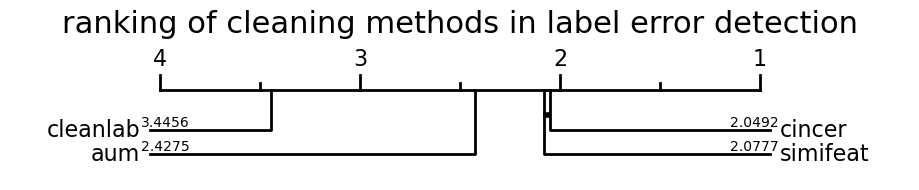

<Figure size 640x480 with 0 Axes>

In [302]:
# Q1

rel_results_df = results_df[results_df["cleaning_method"] != "nocleaning"]
draw_cd_diagram(df_perf=rel_results_df, title='ranking of cleaning methods in label error detection', labels=True, group="cleaning_method", metric="cleaning_f1", filename="q1.png")


In [309]:
rel_results_df = results_df[results_df["downstream_f1"] == 0]
rel_results_df

,Unnamed: 0,dataset,base_model,noise_type,random_seed,cleaning_method,cleaning_f1,downstream_f1
105,105,electricdevices,fcn,no-noise-0.0,42,aum,0.996515,0.0
106,106,electricdevices,fcn,no-noise-0.0,42,cincer,0.924828,0.0
107,107,electricdevices,fcn,no-noise-0.0,42,cleanlab,0.455615,0.0
108,108,electricdevices,fcn,no-noise-0.0,42,simifeat,0.978599,0.0
109,109,electricdevices,fcn,no-noise-0.0,42,nocleaning,0.000000,0.0
...,...,...,...,...,...,...,...,...
1838,1838,tweeteval,all-distilroberta-v1,uniform-0.1,43,simifeat,0.859872,0.0
1844,1844,tweeteval,all-distilroberta-v1,uniform-0.4,43,aum,0.459338,0.0
1845,1845,tweeteval,all-distilroberta-v1,uniform-0.4,43,cincer,0.454227,0.0
1846,1846,tweeteval,all-distilroberta-v1,uniform-0.4,43,cleanlab,0.532768,0.0


DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


['aum' 'cincer' 'cleanlab' 'simifeat' 'nocleaning']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum         100.0
cincer      118.0
cleanlab     48.0
simifeat    120.0
dtype: float64
cleanlab    2.948187
aum         2.384715
simifeat    2.343264
cincer      2.323834
dtype: float64
('cincer', 'cleanlab', 6.247088161635714e-38, True)
('cleanlab', 'simifeat', 2.1585390915513455e-37, True)
('aum', 'cleanlab', 5.393536280345446e-34, True)
('aum', 'cincer', 0.0923302332433125, False)
('aum', 'simifeat', 0.10746317400650336, False)
('cincer', 'simifeat', 0.5635105442646515, False)
Index(['cleanlab', 'aum', 'simifeat', 'cincer'], dtype='object')
[1, 2, 3]


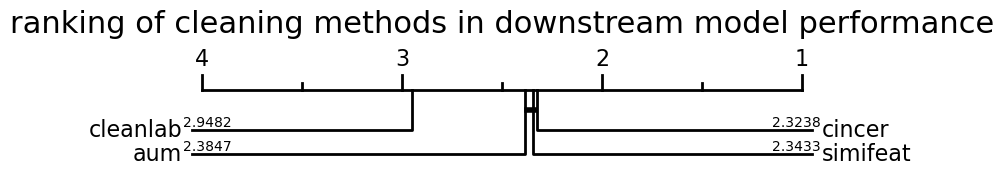

<Figure size 640x480 with 0 Axes>

In [307]:
# Q2
rel_results_df = results_df #[results_df["downstream_f1"] != 0]
#rel_results_df["downstream_f1"] += (np.random.random((len(rel_results_df),))*2-1)/pow(10,3)
draw_cd_diagram(df_perf=rel_results_df, title='ranking of cleaning methods in downstream model performance', labels=True, group="cleaning_method", metric="downstream_f1", filename="q2.png")


In [73]:
def get_noise_name(noise_type):
    if "-" in noise_type:
        return noise_type.rpartition("-")[0]
    return noise_type

results_df["noise_name"] = [get_noise_name(x) for x in results_df["noise_type"]]

array(['uniform', 'asymmetric', 'classdependent', 'instancedependent',
       'no-noise'], dtype=object)

In [75]:
# Q3

for noise_name in results_df["noise_name"].unique():
    rel_results_df = results_df[results_df["noise_name"] == noise_name]
    draw_cd_diagram(df_perf=rel_results_df, title=f'ranking of cleaning methods by noise type: {noise_name}', labels=True, group="cleaning_method", metric="cleaning_f1", filename=f"q3-{noise_name}.png")


DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum         16.0
cincer      47.0
cleanlab     1.0
simifeat    39.0
dtype: float64
cleanlab    3.456311
aum         2.572816
simifeat    2.077670
cincer      1.893204
dtype: float64
('aum', 'simifeat', 9.541900051859445e-17, True)
('cleanlab', 'simifeat', 5.50587345062667e-16, True)
('cincer', 'cleanlab', 2.0245221980394993e-14, True)
('aum', 'cleanlab', 5.746373995806872e-12, True)
('aum', 'cincer', 2.789045900647071e-10, True)
('cincer', 'simifeat', 0.7483852689375422, False)
Index(['cleanlab', 'aum', 'simifeat', 'cincer'], dtype='object')
[2, 3]
['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum         16.0
cincer      44.0
cleanlab     6.0
simifeat    38.0
dtype: float64
cleanlab    3.423077
aum         2.519231
cincer      2.048077
simifeat    2.009615
dtype: float64
('aum', 'si

DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
/zfsauton2/home/arvindsr/anaconda3/envs/labelerrors/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum         14.0
cincer      10.0
cleanlab     1.0
simifeat    16.0
dtype: float64
cleanlab    3.365854
aum         2.365854
cincer      2.292683
simifeat    1.975610
dtype: float64
('aum', 'simifeat', 7.909875421319157e-09, True)
('cleanlab', 'simifeat', 3.9693168218946084e-07, True)
('cincer', 'cleanlab', 1.700526991044171e-05, True)
('aum', 'cleanlab', 0.0002717470342759043, True)
('cincer', 'simifeat', 0.009915348819675263, True)
('aum', 'cincer', 0.03843086781580496, True)
Index(['cleanlab', 'aum', 'cincer', 'simifeat'], dtype='object')
['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum         20.0
cincer      45.0
cleanlab     6.0
simifeat    33.0
dtype: float64
cleanlab    3.500000
aum         2.509615
simifeat    2.028846
cincer      1.961538
dtype: float64
('aum', 'simifeat'

DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


/zfsauton2/home/arvindsr/anaconda3/envs/labelerrors/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum         15.0
cincer       9.0
cleanlab     1.0
simifeat     7.0
dtype: float64
cleanlab    3.878788
simifeat    2.287879
cincer      2.196970
aum         1.636364
dtype: float64
('cincer', 'cleanlab', 2.3283064365386963e-10, True)
('cleanlab', 'simifeat', 2.3283064365386963e-10, True)
('aum', 'cleanlab', 1.1641532182693481e-09, True)
('aum', 'simifeat', 8.295220322906971e-05, True)
('aum', 'cincer', 0.0011035518255084753, True)
('cincer', 'simifeat', 0.07111807531952284, False)
Index(['cleanlab', 'simifeat', 'cincer', 'aum'], dtype='object')
[1, 2]


In [79]:
# Q4

for noise_name in results_df["noise_name"].unique():
    rel_results_df = results_df #[results_df["downstream_f1"] != 0]
    rel_results_df = rel_results_df[rel_results_df["noise_name"] == noise_name]
    draw_cd_diagram(df_perf=rel_results_df, title=f'ranking of cleaning methods (downstream) by noise type: {noise_name}', labels=True, group="cleaning_method", metric="downstream_f1", filename=f"q4-{noise_name}.png")


DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum         28.0
cincer      31.0
cleanlab    12.0
simifeat    32.0
dtype: float64
cleanlab    2.878641
aum         2.451456
cincer      2.334951
simifeat    2.334951
dtype: float64
('cincer', 'cleanlab', 3.147862669983449e-11, True)
('cleanlab', 'simifeat', 4.744785100532514e-10, True)
('aum', 'cleanlab', 1.9162452000219186e-09, True)
('cincer', 'simifeat', 0.028549462015365172, False)
('aum', 'cincer', 0.06771000787471693, False)
('aum', 'simifeat', 0.6985913527325953, False)
Index(['cleanlab', 'aum', 'cincer', 'simifeat'], dtype='object')
[1, 2, 3]
['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum         30.0
cincer      32.0
cleanlab    12.0
simifeat    28.0
dtype: float64
cleanlab    2.932692
cincer      2.389423
simifeat    2.379808
aum         2.298077
dtype: float64
('cleanl

DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


/zfsauton2/home/arvindsr/anaconda3/envs/labelerrors/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/tmp/ipykernel_570032/3078927055.py:145: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(width, height))
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adju

DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum          9.0
cincer      13.0
cleanlab     7.0
simifeat    11.0
dtype: float64
cleanlab    2.719512
aum         2.487805
simifeat    2.426829
cincer      2.365854
dtype: float64
('cleanlab', 'simifeat', 8.316626523702693e-05, True)
('cincer', 'cleanlab', 0.00018548625996695587, True)
('aum', 'cleanlab', 0.001377560781877703, True)
('cincer', 'simifeat', 0.2902022502046169, False)
('aum', 'cincer', 0.4578780571499085, False)
('aum', 'simifeat', 0.5167509082240709, False)
Index(['cleanlab', 'aum', 'simifeat', 'cincer'], dtype='object')
[1, 2, 3]
['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum         28.0
cincer      30.0
cleanlab    13.0
simifeat    32.0
dtype: float64
cleanlab    2.841346
aum         2.456731
cincer      2.355769
simifeat    2.346154
dtype: float64
('cincer', '

DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
/zfsauton2/home/arvindsr/anaconda3/envs/labelerrors/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum         7.0
cincer      8.0
cleanlab    5.0
simifeat    9.0
dtype: float64
cleanlab    2.696970
aum         2.500000
simifeat    2.409091
cincer      2.393939
dtype: float64
('cincer', 'cleanlab', 0.0017731852871942354, True)
('cleanlab', 'simifeat', 0.00202040910989954, True)
('aum', 'cleanlab', 0.02520596868934006, False)
('aum', 'simifeat', 0.3886421386743234, False)
('cincer', 'simifeat', 0.5436012237976748, False)
('aum', 'cincer', 0.575781061005763, False)
Index(['cleanlab', 'aum', 'simifeat', 'cincer'], dtype='object')
[1, 0]
[1, 2, 3]


In [84]:
MODEL_TO_MODALITY = {"resnet1d": "time-series",
                    "fcn": "time-series",
                    "mlp": "tabular",
                    "resnet18": "image",
                    "mobilenet-v2": "image",
                    "all-distilroberta-v1": "text",
                    "all-MiniLM-L6-v2": "text"}

results_df["modality"] = [MODEL_TO_MODALITY[x] for x in results_df["base_model"]]

In [86]:
# Q5ai

for modality in results_df["modality"].unique():
    rel_results_df = results_df[results_df["modality"] == modality]
    draw_cd_diagram(df_perf=rel_results_df, title=f'ranking of cleaning methods by modality: {modality}', labels=True, group="cleaning_method", metric="cleaning_f1", filename=f"q5ai-{modality}.png")
    

DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum         38.0
cincer      79.0
cleanlab     1.0
simifeat    61.0
dtype: float64
cleanlab    3.748603
aum         2.452514
cincer      1.905028
simifeat    1.893855
dtype: float64
('aum', 'simifeat', 4.559752395922305e-30, True)
('cleanlab', 'simifeat', 1.1472850498333175e-29, True)
('cincer', 'cleanlab', 2.0644087622354824e-28, True)
('aum', 'cleanlab', 6.211523321619432e-25, True)
('aum', 'cincer', 1.6633248782080891e-18, True)
('cincer', 'simifeat', 0.5723097591175523, False)
Index(['cleanlab', 'aum', 'cincer', 'simifeat'], dtype='object')
[2, 3]
['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum         25.0
cincer      43.0
cleanlab     8.0
simifeat    32.0
dtype: float64
cleanlab    3.092593
aum         2.500000
simifeat    2.250000
cincer      2.157407
dtype: float64
('cleanl

DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum         11.0
cincer      11.0
cleanlab     6.0
simifeat    22.0
dtype: float64
cleanlab    3.44
aum         2.36
cincer      2.32
simifeat    1.88
dtype: float64
('cincer', 'cleanlab', 3.256713547727941e-07, True)
('cleanlab', 'simifeat', 6.78354924232849e-07, True)
('aum', 'cleanlab', 1.3667570399888973e-06, True)
('aum', 'simifeat', 0.007609452352863144, True)
('cincer', 'simifeat', 0.2954728324166016, False)
('aum', 'cincer', 0.6736344940466168, False)
Index(['cleanlab', 'aum', 'cincer', 'simifeat'], dtype='object')
[2, 1]
[2, 3]
['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum         13.0
cincer      16.0
cleanlab     4.0
simifeat    15.0
dtype: float64
cleanlab    2.958333
aum         2.479167
cincer      2.354167
simifeat    2.208333
dtype: float64
('aum', 'simifeat', 4.1

DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


In [88]:
# Q5aii

for modality in results_df["modality"].unique():
    rel_results_df = results_df #[results_df["downstream_f1"] != 0]
    rel_results_df = rel_results_df[rel_results_df["modality"] == modality]
    draw_cd_diagram(df_perf=rel_results_df, title=f'ranking of cleaning methods by modality: {modality}', labels=True, group="cleaning_method", metric="downstream_f1", filename=f"q5aii-{modality}.png")
    

DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum         47.0
cincer      63.0
cleanlab    13.0
simifeat    56.0
dtype: float64
cleanlab    3.008380
aum         2.393855
simifeat    2.326816
cincer      2.270950
dtype: float64
('cincer', 'cleanlab', 3.0467320708622655e-21, True)
('cleanlab', 'simifeat', 1.5347026391080416e-20, True)
('aum', 'cleanlab', 7.530679120015203e-20, True)
('aum', 'simifeat', 0.14988279941877808, False)
('cincer', 'simifeat', 0.2817273586625163, False)
('aum', 'cincer', 0.9434053536329668, False)
Index(['cleanlab', 'aum', 'simifeat', 'cincer'], dtype='object')
[1, 2, 3]
['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum         27.0
cincer      28.0
cleanlab    16.0
simifeat    28.0
dtype: float64
cleanlab    2.625000
aum         2.467593
cincer      2.453704
simifeat    2.453704
dtype: float64
('cleanla

DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


/zfsauton2/home/arvindsr/anaconda3/envs/labelerrors/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


Index(['cleanlab', 'aum', 'cincer', 'simifeat'], dtype='object')
[1, 2, 3]
['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum         11.0
cincer      15.0
cleanlab     7.0
simifeat    16.0
dtype: float64
cleanlab    3.01
aum         2.36
cincer      2.33
simifeat    2.30
dtype: float64
('cleanlab', 'simifeat', 2.2480464576117378e-05, True)
('cincer', 'cleanlab', 2.3738408042363446e-05, True)
('aum', 'cleanlab', 3.9144105248810714e-05, True)
('aum', 'cincer', 0.037256553473125426, False)
('aum', 'simifeat', 0.11456882433537673, False)
('cincer', 'simifeat', 0.24194571339726378, False)
Index(['cleanlab', 'aum', 'cincer', 'simifeat'], dtype='object')
[1, 2, 3]


DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
/zfsauton2/home/arvindsr/anaconda3/envs/labelerrors/lib/python3.8/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


['aum' 'cincer' 'cleanlab' 'simifeat']
aum cincer
aum cleanlab
aum simifeat
cincer cleanlab
cincer simifeat
cleanlab simifeat
aum         11.0
cincer      12.0
cleanlab    11.0
simifeat    13.0
dtype: float64
aum         2.541667
cleanlab    2.531250
simifeat    2.489583
cincer      2.437500
dtype: float64
('cincer', 'cleanlab', 0.0010751738334810823, True)
('cleanlab', 'simifeat', 0.001954849595223946, True)
('aum', 'cincer', 0.015688828016009605, False)
('aum', 'simifeat', 0.04645237826007202, False)
('cincer', 'simifeat', 0.09338948702552936, False)
('aum', 'cleanlab', 0.18741729557880982, False)
Index(['aum', 'cleanlab', 'simifeat', 'cincer'], dtype='object')
[0, 1]
[0, 2, 3]


DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting
DEBUG:matplotlib.axes._base:title position was updated manually, not adjusting


In [189]:
# Model Consistency

results_dict["cifar10"]["resnet18"]["no-noise-0.0"]["42"]["datacard"]

,is_injected_noise,noisy_label,label_issues_cincer,preds_cleaned_cincer,label_issues_aum,preds_cleaned_aum,label_issues_simifeat,preds_cleaned_simifeat,label_issues_cleanlab,preds_cleaned_cleanlab,observed_labels
0,0,6,0,6,0,6,0,6,1,5,6
1,0,9,0,9,0,9,0,9,1,1,9
2,0,9,0,9,0,9,0,9,1,7,9
3,0,4,0,4,0,4,0,4,1,4,4
4,0,1,0,1,0,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
49995,0,2,0,2,1,0,0,2,1,8,2
49996,0,6,1,2,1,3,0,6,1,1,6
49997,0,9,0,9,1,8,0,9,1,9,9
49998,0,1,0,1,1,1,0,1,0,1,1


In [137]:
# Model Consistency


In [244]:
from copy import deepcopy

d1 = deepcopy(results_dict["clothing100k"]["resnet18"]["no-noise-0.0"]["42"]["datacard"])
d1.columns = [col+"_resnet18" for col in d1.columns]
d2 = deepcopy(results_dict["clothing100k"]["mobilenet-v2"]["no-noise-0.0"]["42"]["datacard"])
d2.columns = [col+"_mobilenet-v2" for col in d2.columns]
datacard = pd.concat([d1, d2], axis=1)
ignore_set = {"is_injected_noise", "observed_labels", "preds_cleaned", "noisy_label"}
datacard = datacard.drop(columns=[col for col in datacard.columns if any(col.startswith(x) for x in ignore_set)])
datacard

,label_issues_cincer_resnet18,label_issues_aum_resnet18,label_issues_simifeat_resnet18,label_issues_cleanlab_resnet18,label_issues_simifeat_mobilenet-v2,label_issues_aum_mobilenet-v2,label_issues_cincer_mobilenet-v2,label_issues_cleanlab_mobilenet-v2
0,1,0,0,1,0,0,0,1
1,0,0,0,0,0,0,0,1
2,1,0,0,1,0,0,0,1
3,0,0,0,1,0,0,0,1
4,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...
94270,0,1,0,0,0,1,0,1
94271,0,1,0,1,0,1,0,1
94272,0,1,0,1,0,1,0,1
94273,0,1,0,1,0,1,0,1


In [245]:
X_train = datacard.values

In [246]:
from snorkel.labeling.model.label_model import LabelModel

In [247]:
label_model = LabelModel(cardinality=2)
label_model.fit(X_train, class_balance=[0.9, 0.1], n_epochs=500)

INFO:root:Computing O...
INFO:root:Estimating \mu...
  0%|                                                         | 0/500 [00:00<?, ?epoch/s]INFO:root:[0 epochs]: TRAIN:[loss=45.080]
INFO:root:[10 epochs]: TRAIN:[loss=7.503]
INFO:root:[20 epochs]: TRAIN:[loss=3.756]
INFO:root:[30 epochs]: TRAIN:[loss=2.318]
INFO:root:[40 epochs]: TRAIN:[loss=0.845]
INFO:root:[50 epochs]: TRAIN:[loss=0.152]
INFO:root:[60 epochs]: TRAIN:[loss=0.056]
INFO:root:[70 epochs]: TRAIN:[loss=0.073]
INFO:root:[80 epochs]: TRAIN:[loss=0.066]
INFO:root:[90 epochs]: TRAIN:[loss=0.055]
INFO:root:[100 epochs]: TRAIN:[loss=0.051]
INFO:root:[110 epochs]: TRAIN:[loss=0.051]
INFO:root:[120 epochs]: TRAIN:[loss=0.050]
INFO:root:[130 epochs]: TRAIN:[loss=0.048]
INFO:root:[140 epochs]: TRAIN:[loss=0.047]
INFO:root:[150 epochs]: TRAIN:[loss=0.046]
INFO:root:[160 epochs]: TRAIN:[loss=0.045]
INFO:root:[170 epochs]: TRAIN:[loss=0.043]
INFO:root:[180 epochs]: TRAIN:[loss=0.042]
 36%|████████████████▍                            |

In [248]:
probas = label_model.predict_proba(X_train)
sorted(enumerate(probas), key=lambda x: x[1][1], reverse=True)

[(65322, array([0.1043085, 0.8956915])),
 (65865, array([0.1043085, 0.8956915])),
 (66020, array([0.1043085, 0.8956915])),
 (66692, array([0.1043085, 0.8956915])),
 (66720, array([0.1043085, 0.8956915])),
 (68269, array([0.1043085, 0.8956915])),
 (69857, array([0.1043085, 0.8956915])),
 (70454, array([0.1043085, 0.8956915])),
 (70532, array([0.1043085, 0.8956915])),
 (70752, array([0.1043085, 0.8956915])),
 (71788, array([0.1043085, 0.8956915])),
 (72032, array([0.1043085, 0.8956915])),
 (72180, array([0.1043085, 0.8956915])),
 (25329, array([0.12822641, 0.87177359])),
 (25394, array([0.12822641, 0.87177359])),
 (25760, array([0.12822641, 0.87177359])),
 (26169, array([0.12822641, 0.87177359])),
 (26245, array([0.12822641, 0.87177359])),
 (26332, array([0.12822641, 0.87177359])),
 (26463, array([0.12822641, 0.87177359])),
 (26968, array([0.12822641, 0.87177359])),
 (27136, array([0.12822641, 0.87177359])),
 (27542, array([0.12822641, 0.87177359])),
 (27716, array([0.12822641, 0.8717735

In [203]:
preds = label_model.predict(X_train)
preds.mean()

0.03338

In [310]:
from aqua.configs import data_configs
from aqua.data.preset_dataloaders import load_cifar10, load_mitbih, load_clothing100k

def load_tensorflow_format_dataset(par_path: str):
    labels, filenames = [], []

    for label in os.listdir(par_path):
        label_dir = os.path.join(par_path, label)
        for files in os.listdir(label_dir):
            labels.append(label)
            filenames.append(os.path.join(label_dir, files))

    return np.array(filenames), np.array(labels)

from aqua.configs import data_configs

cfg = data_configs['clothing100k']
train_file_dir = cfg['train']['data']
test_file_dir = cfg['test']['data']

train_data, train_labels = load_tensorflow_format_dataset(train_file_dir)
test_data, test_labels = load_tensorflow_format_dataset(test_file_dir)

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


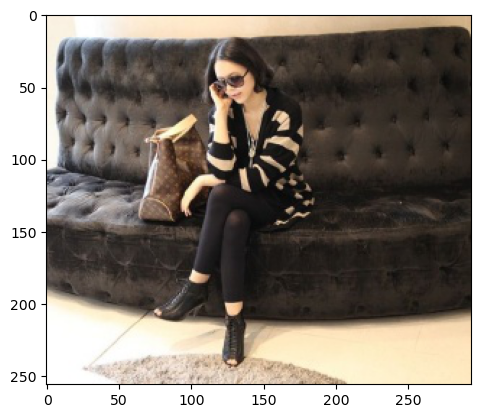

In [320]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

idx = 65322

plt.Figure(figsize=(8, 8))
image = np.asarray(Image.open(train_data[idx]))
#image = np.transpose(image, (1, 2, 0))
label = train_labels[idx]
plt.imshow(image.astype(np.uint8))
plt.show()

In [321]:
print(label)

knitwear


In [295]:
list(enumerate(['chiffon', 'downcoat', 'dress', 'hoodie', 'jacket', 'knitwear', 'shawl', 'shirt',
 'suit', 'sweater', 'tshirt', 'underwear', 'vest', 'windbreaker']))

[(0, 'chiffon'),
 (1, 'downcoat'),
 (2, 'dress'),
 (3, 'hoodie'),
 (4, 'jacket'),
 (5, 'knitwear'),
 (6, 'shawl'),
 (7, 'shirt'),
 (8, 'suit'),
 (9, 'sweater'),
 (10, 'tshirt'),
 (11, 'underwear'),
 (12, 'vest'),
 (13, 'windbreaker')]

In [ ]:
# 26245
# 25760
# 